## **Data Understanding, Analysis, Visualization and Cleaning**
# DONT RUN ALLL PLEASSEEEEEE REMEMBER

The dataset represents categorized images of garbage materials, designed for building an image classification model that can distinguish between different types of waste. This aligns with sustainability goals by potentially enabling smart waste sorting solutions. The dataset is organized into five main categories:

1.   Plastic Waste
2.   Paper Waste
3. Metal

4. Glass Waste

5. Organic Garbage

Each category contains image samples used to train and test the model on identifying waste type from a photo input.

In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import os

base_dir = '/content/drive/MyDrive/garbage_dataset'

### **Total number of images in dataset**

In [ ]:
import os

categories = ['plastic waste', 'paper waste', 'metal', 'glass waste', 'organic garbage']
base_dir = '/content/drive/MyDrive/garbage_dataset'

total_train_images = 0
total_test_images = 0

for category in categories:
    folder_name = category.replace(" ", "_")

    train_path = os.path.join(base_dir, 'train', folder_name)
    if os.path.exists(train_path):
        train_count = sum([1 for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))])
        total_train_images += train_count
        print(f"{category} - Train images: {train_count}")
    else:
        print(f"Train folder for '{category}' not found.")

    test_path = os.path.join(base_dir, 'test', folder_name)
    if os.path.exists(test_path):
        test_count = sum([1 for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))])
        total_test_images += test_count
        print(f"{category} - Test images: {test_count}")
    else:
        print(f"Test folder for '{category}' not found.")

print(f"Total Train Images: {total_train_images}")
print(f"Total Test Images: {total_test_images}")
print(f"Total Images in Dataset: {total_train_images + total_test_images}")


plastic waste - Train images: 554
plastic waste - Test images: 111
paper waste - Train images: 600
paper waste - Test images: 109
metal - Train images: 517
metal - Test images: 128
glass waste - Train images: 567
glass waste - Test images: 116
organic garbage - Train images: 546
organic garbage - Test images: 143
Total Train Images: 2784
Total Test Images: 607
Total Images in Dataset: 3391


### **Distribution of images across different classes**

In [ ]:
import pandas as pd

# Prepare a list to store data
data = []

for category in categories:
    folder_name = category.replace(" ", "_")

    # Train
    train_path = os.path.join(base_dir, 'train', folder_name)
    train_count = sum([1 for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]) if os.path.exists(train_path) else 0

    # Test
    test_path = os.path.join(base_dir, 'test', folder_name)
    test_count = sum([1 for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]) if os.path.exists(test_path) else 0

    # Append to data list
    data.append({
        "Category": category,
        "Train Images": train_count,
        "Test Images": test_count,
        "Total": train_count + test_count
    })

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

# Optional: show total row
print("\n Total Summary:")
print(df[["Train Images", "Test Images", "Total"]].sum().to_frame().T)


          Category  Train Images  Test Images  Total
0    plastic waste           554          111    665
1      paper waste           600          109    709
2            metal           517          128    645
3      glass waste           567          116    683
4  organic garbage           546          143    689

 Total Summary:
   Train Images  Test Images  Total
0          2784          607   3391


### **Dataset Split into training and validation sets**
The dataset is split into:

1. Training Set: 80%

2. Validation/Test Set: 20%

This common split ensures enough data is available for learning, while still maintaining a sufficient test set to evaluate generalization performance. The split was done by creating separate train and test folders for each class manually.

### **Data Preprocessing**
**Resizing and Normalization**

In [ ]:
from PIL import Image
import numpy as np

IMG_SIZE = (224, 224)

def preprocess_images(directory):
    for category in categories:
        folder_name = category.replace(" ", "_")
        folder_path = os.path.join(directory, folder_name)

        if not os.path.exists(folder_path):
            continue

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                try:
                    img = Image.open(file_path).convert("RGB")
                    img = img.resize(IMG_SIZE)
                    img_array = np.array(img) / 255.0  # Normalize
                    img = Image.fromarray((img_array * 255).astype('uint8'))
                    img.save(file_path)
                except Exception as e:
                    print(f"Failed to process {file_path}: {e}")

preprocess_images(os.path.join(base_dir, 'train'))
preprocess_images(os.path.join(base_dir, 'test'))


**Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

TARGETS = {'train': 600, 'test': 150}

categories = ['plastic waste', 'paper waste', 'metal', 'glass waste', 'organic garbage']
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

def augment_to_target(directory, target_count):
    for category in categories:
        folder_name = category.replace(" ", "_")
        folder_path = os.path.join(directory, folder_name)
        if not os.path.exists(folder_path):
            continue

        image_files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        count = len(image_files)

        if count >= target_count:
            continue

        i = 0
        while count < target_count:
            img_file = image_files[i % len(image_files)]
            img_path = os.path.join(folder_path, img_file)

            img = load_img(img_path, target_size=IMG_SIZE)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            gen = datagen.flow(x, batch_size=1, save_to_dir=folder_path,
                               save_prefix='aug', save_format='jpg')
            next(gen)

            count += 1
            i += 1

# Apply to train and test folders
augment_to_target(os.path.join(base_dir, 'train'), TARGETS['train'])
augment_to_target(os.path.join(base_dir, 'test'), TARGETS['test'])


**Counting Images after data augmentation**

In [ ]:
import pandas as pd

# Prepare a list to store data
data = []

for category in categories:
    folder_name = category.replace(" ", "_")

    # Train
    train_path = os.path.join(base_dir, 'train', folder_name)
    train_count = sum([1 for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]) if os.path.exists(train_path) else 0

    # Test
    test_path = os.path.join(base_dir, 'test', folder_name)
    test_count = sum([1 for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]) if os.path.exists(test_path) else 0

    # Append to data list
    data.append({
        "Category": category,
        "Train Images": train_count,
        "Test Images": test_count,
        "Total": train_count + test_count
    })

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

# Optional: show total row
print("\n Total Summary:")
print(df[["Train Images", "Test Images", "Total"]].sum().to_frame().T)


          Category  Train Images  Test Images  Total
0    plastic waste           600          150    750
1      paper waste           600          150    750
2            metal           600          150    750
3      glass waste           600          150    750
4  organic garbage           600          150    750

 Total Summary:
   Train Images  Test Images  Total
0          3000          750   3750


In [ ]:
import pandas as pd

# Prepare a list to store data
data = []
categories = ['plastic waste', 'paper waste', 'metal', 'glass waste', 'organic garbage']

for category in categories:
    folder_name = category.replace(" ", "_")

    # Train
    train_path = os.path.join(base_dir, 'train', folder_name)
    train_count = sum([1 for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]) if os.path.exists(train_path) else 0

    # Test
    test_path = os.path.join(base_dir, 'test', folder_name)
    test_count = sum([1 for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]) if os.path.exists(test_path) else 0

    # Append to data list
    data.append({
        "Category": category,
        "Train Images": train_count,
        "Test Images": test_count,
        "Total": train_count + test_count
    })

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

# Optional: show total row
print("\n Total Summary:")
print(df[["Train Images", "Test Images", "Total"]].sum().to_frame().T)


          Category  Train Images  Test Images  Total
0    plastic waste           600          150    750
1      paper waste           600          150    750
2            metal           600          150    750
3      glass waste           600          150    750
4  organic garbage           600          150    750

 Total Summary:
   Train Images  Test Images  Total
0          3000          750   3750


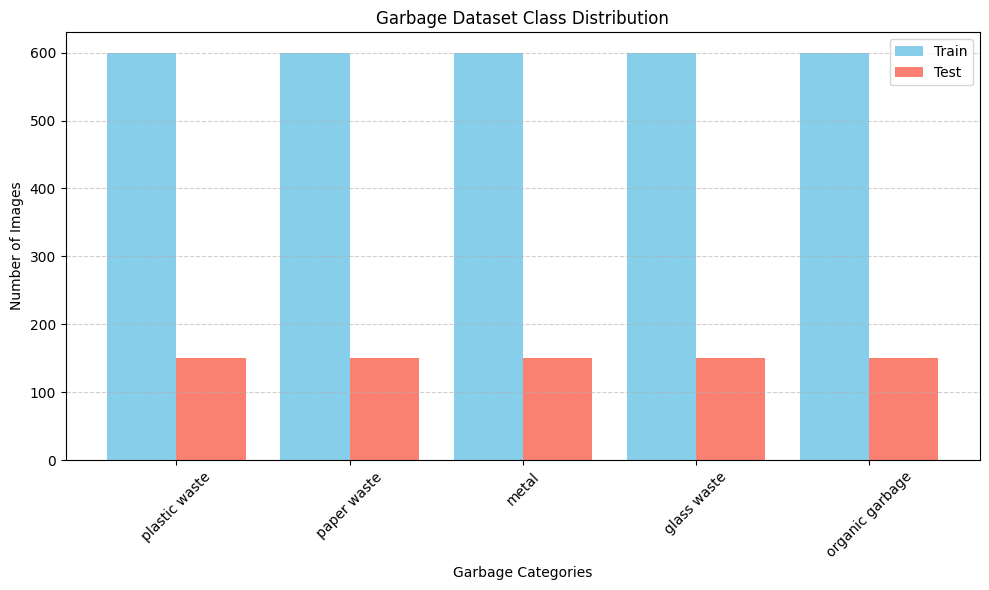

In [ ]:
import os
import matplotlib.pyplot as plt

categories = ['plastic waste', 'paper waste', 'metal', 'glass waste', 'organic garbage']
base_dir = '/content/drive/MyDrive/garbage_dataset'

train_counts, test_counts = [], []

for category in categories:
    folder = category.replace(" ", "_")
    train_path = os.path.join(base_dir, 'train', folder)
    test_path = os.path.join(base_dir, 'test', folder)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    train_counts.append(train_count)
    test_counts.append(test_count)

# Plot
x = range(len(categories))
plt.figure(figsize=(10,6))
plt.bar(x, train_counts, width=0.4, label='Train', align='center', color='skyblue')
plt.bar([i + 0.4 for i in x], test_counts, width=0.4, label='Test', align='center', color='salmon')
plt.xticks([i + 0.2 for i in x], categories, rotation=45)
plt.xlabel("Garbage Categories")
plt.ylabel("Number of Images")
plt.title("Garbage Dataset Class Distribution")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


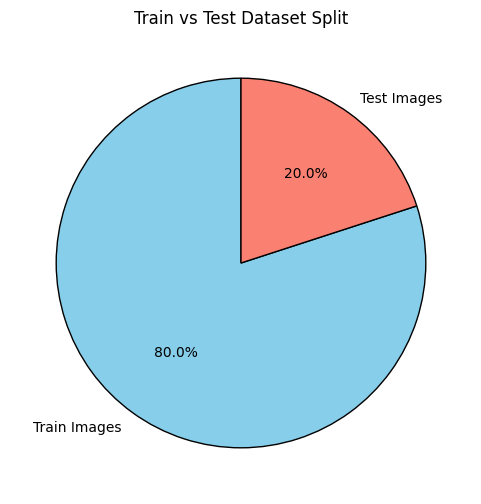

In [ ]:
import matplotlib.pyplot as plt

# Totals
total_train = sum(train_counts)
total_test = sum(test_counts)

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [total_train, total_test],
    labels=['Train Images', 'Test Images'],
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Train vs Test Dataset Split')
plt.show()


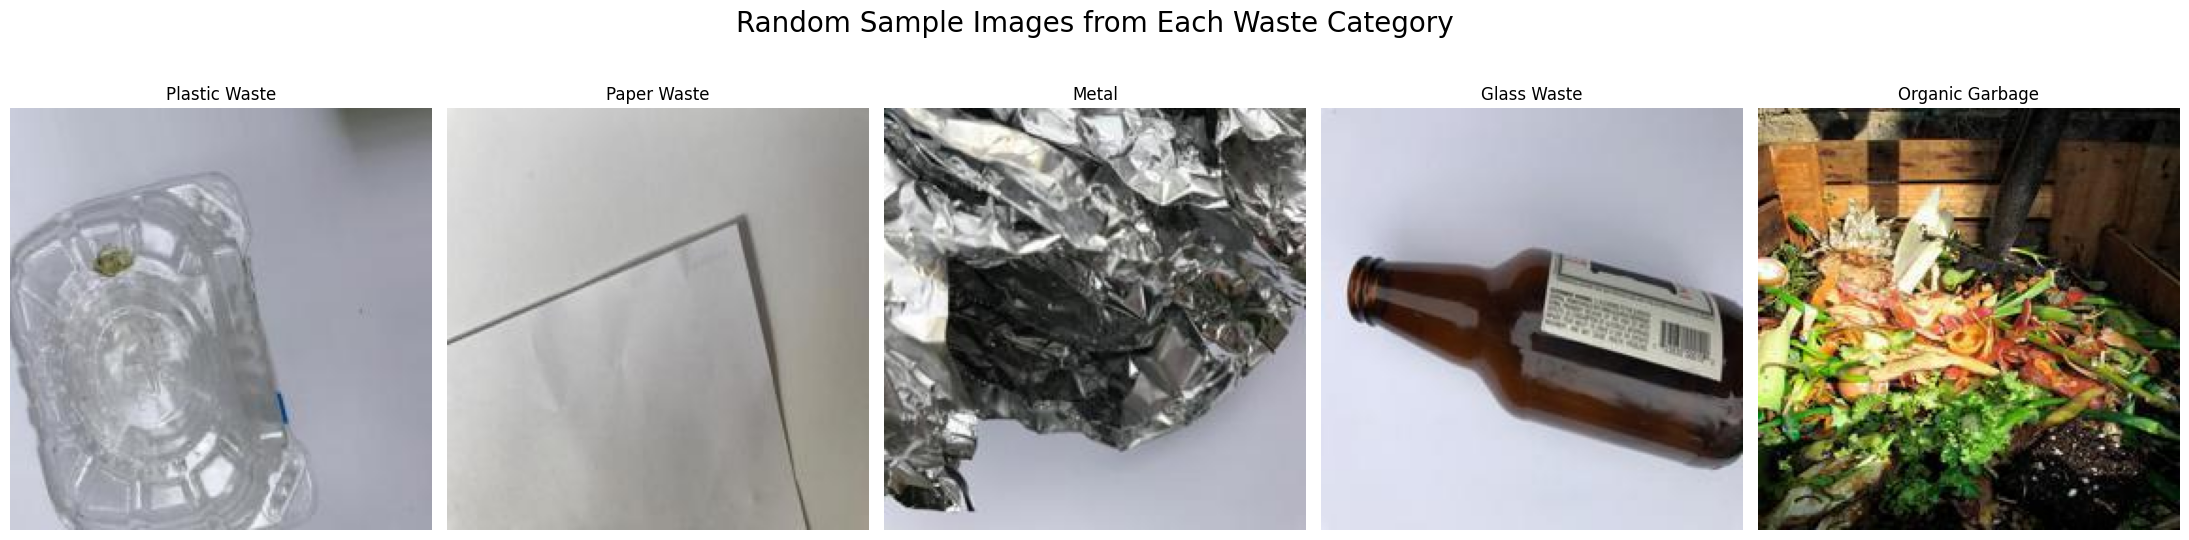

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

fig, axs = plt.subplots(1, 5, figsize=(22, 6))

for i, category in enumerate(categories):
    folder_name = category.replace(" ", "_")
    sample_path = os.path.join(base_dir, 'train', folder_name)

    if os.path.exists(sample_path) and len(os.listdir(sample_path)) > 0:
        image_list = os.listdir(sample_path)
        random_img = random.choice(image_list)
        img = mpimg.imread(os.path.join(sample_path, random_img))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(category.title())

plt.suptitle('Random Sample Images from Each Waste Category', fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image

# Set base directory (your dataset root in Drive)
base_dir = '/content/drive/MyDrive/garbage_dataset'

# Define subfolders
subfolders = ['train', 'test']
corrupted_images = []

# Loop through train and test
for subfolder in subfolders:
    folder_path = os.path.join(base_dir, subfolder)
    if not os.path.exists(folder_path):
        print(f"❌ {subfolder} folder not found.")
        continue

    # Loop through category folders
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if not os.path.isdir(category_path):
            continue

        # Check all images
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Validate image
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)  # Optional: remove corrupted image
                print(f"Removed corrupted image: {image_path}")

# Print result summary
if not corrupted_images:
    print("No Corrupted Images Found.")
else:
    print(f"Total Corrupted Images Removed: {len(corrupted_images)}")


No Corrupted Images Found.


### **Preprocessing Techniques**
Before feeding data into the model, the following preprocessing steps were used:

1. Resizing: All images resized to (224x224) to standardize input shape.

2. Normalization: Pixel values scaled between 0 and 1 using ImageDataGenerator(rescale=1./255).

3. Conversion: Images were loaded in RGB and converted to float arrays suitable for CNNs.


### **Visualization of Augmented Images**

### **Data Generators Used**
The ImageDataGenerator from Keras was used to load the data from folders initially and then normalize, and apply real-time data augmentation.

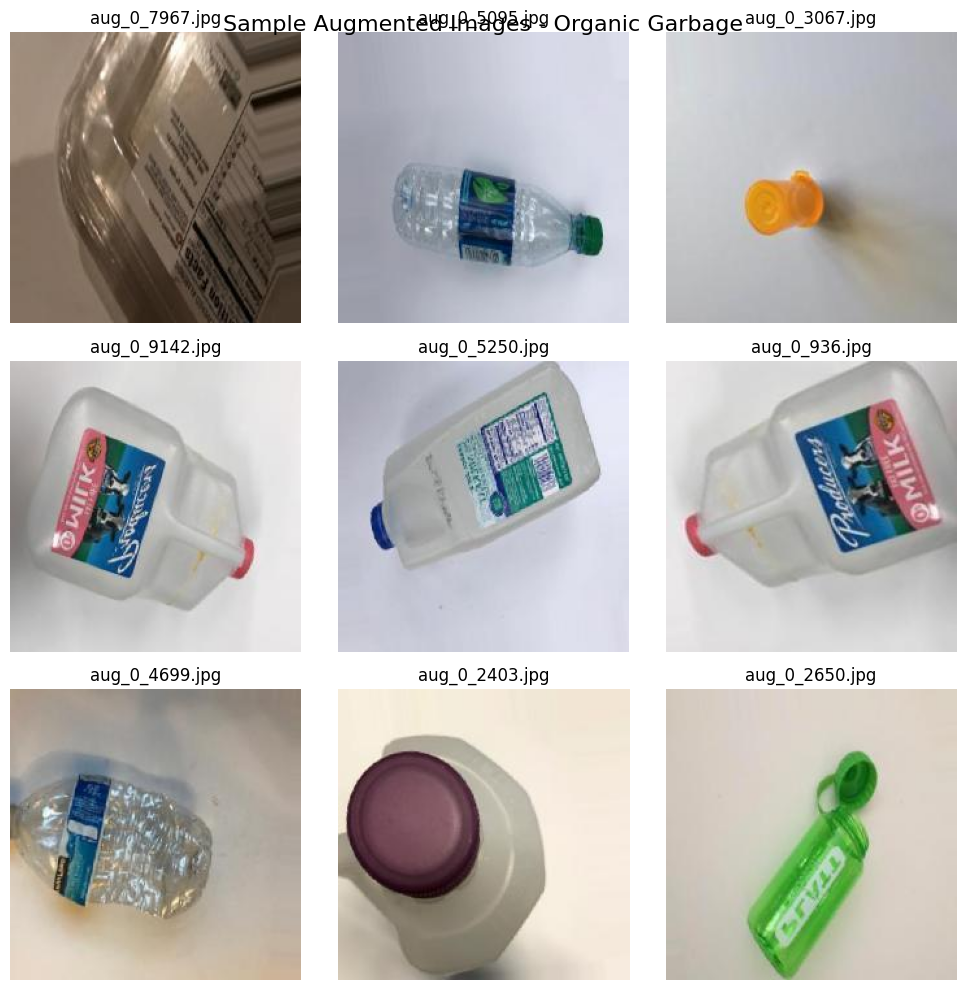

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Path to the folder where augmented images are stored
aug_folder = os.path.join(base_dir, 'train', 'plastic_waste')

# Filter augmented images (usually prefixed with "aug")
aug_images = [f for f in os.listdir(aug_folder) if f.startswith('aug') and f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Select a few images to display
sample_images = random.sample(aug_images, min(9, len(aug_images)))

# Plotting
plt.figure(figsize=(10, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(aug_folder, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
plt.tight_layout()
plt.suptitle('Sample Augmented Images - Organic Garbage', fontsize=16)
plt.show()


### **Design, Train, and Evaluate a Baseline Model**
**Model Architecture- Baseline CNN**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/garbage_dataset/test'
train_dir = '/content/drive/MyDrive/garbage_dataset/train'


input_shape = (224, 224, 3)
num_classes = 5  # Update if needed

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
     rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


# Load test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 744 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

baseline_model = Sequential([
     Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    # BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    # BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    # BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    # Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    Dense(num_classes, activation='softmax')
])



In [ ]:
baseline_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

baseline_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,286,149 (85.01 MB)

 Trainable params: 22,286,149 (85.01 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# Path to save the best model
best_model_path = '/content/drive/MyDrive/best_model.h5'

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True)



In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:

# Measure training time
start_time = time.time()

# Train the model
baseline_history = baseline_model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    epochs=20,
    validation_steps=len(val_gen),
    verbose=2,
    callbacks=[early_stop, model_checkpoint]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Model training time: {training_time:.2f} seconds")

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.41424, saving model to /content/drive/MyDrive/best_model.h5


75/75 - 165s - 2s/step - accuracy: 0.4629 - loss: 1.2822 - val_accuracy: 0.4383 - val_loss: 1.4142
Epoch 2/20

Epoch 2: val_loss did not improve from 1.41424
75/75 - 87s - 1s/step - accuracy: 0.4638 - loss: 1.2335 - val_accuracy: 0.4617 - val_loss: 1.5130
Epoch 3/20

Epoch 3: val_loss improved from 1.41424 to 1.40491, saving model to /content/drive/MyDrive/best_model.h5


75/75 - 86s - 1s/step - accuracy: 0.4933 - loss: 1.1808 - val_accuracy: 0.4583 - val_loss: 1.4049
Epoch 4/20

Epoch 4: val_loss improved from 1.40491 to 1.31518, saving model to /content/drive/MyDrive/best_model.h5


75/75 - 61s - 809ms/step - accuracy: 0.5450 - loss: 1.1246 - val_accuracy: 0.5417 - val_loss: 1.3152
Epoch 5/20

Epoch 5: val_loss did not improve from 1.31518
75/75 - 74s - 981ms/step - accuracy: 0.5567 - loss: 1.0757 - val_accuracy: 0.5200 - val_loss: 1.3845
Epoch 6/20

Epoch 6: val_loss improved from 1.31518 to 1.30837, saving model to /content/drive/MyDrive/best_model.h5


75/75 - 85s - 1s/step - accuracy: 0.5933 - loss: 1.0432 - val_accuracy: 0.6083 - val_loss: 1.3084
Epoch 7/20

Epoch 7: val_loss did not improve from 1.30837
75/75 - 56s - 748ms/step - accuracy: 0.5933 - loss: 0.9967 - val_accuracy: 0.6183 - val_loss: 1.3480
Epoch 8/20

Epoch 8: val_loss improved from 1.30837 to 1.23928, saving model to /content/drive/MyDrive/best_model.h5


75/75 - 57s - 760ms/step - accuracy: 0.6521 - loss: 0.9144 - val_accuracy: 0.6317 - val_loss: 1.2393
Epoch 9/20

Epoch 9: val_loss did not improve from 1.23928
75/75 - 57s - 756ms/step - accuracy: 0.6475 - loss: 0.9078 - val_accuracy: 0.6233 - val_loss: 1.2887
Epoch 10/20

Epoch 10: val_loss did not improve from 1.23928
75/75 - 74s - 992ms/step - accuracy: 0.6463 - loss: 0.9079 - val_accuracy: 0.6150 - val_loss: 1.3140
Epoch 11/20

Epoch 11: val_loss did not improve from 1.23928
75/75 - 50s - 671ms/step - accuracy: 0.6833 - loss: 0.8353 - val_accuracy: 0.6000 - val_loss: 1.3399
Epoch 12/20

Epoch 12: val_loss did not improve from 1.23928
75/75 - 81s - 1s/step - accuracy: 0.7008 - loss: 0.7945 - val_accuracy: 0.5983 - val_loss: 1.3296
Model training time: 933.96 seconds


**Model Evaluation**

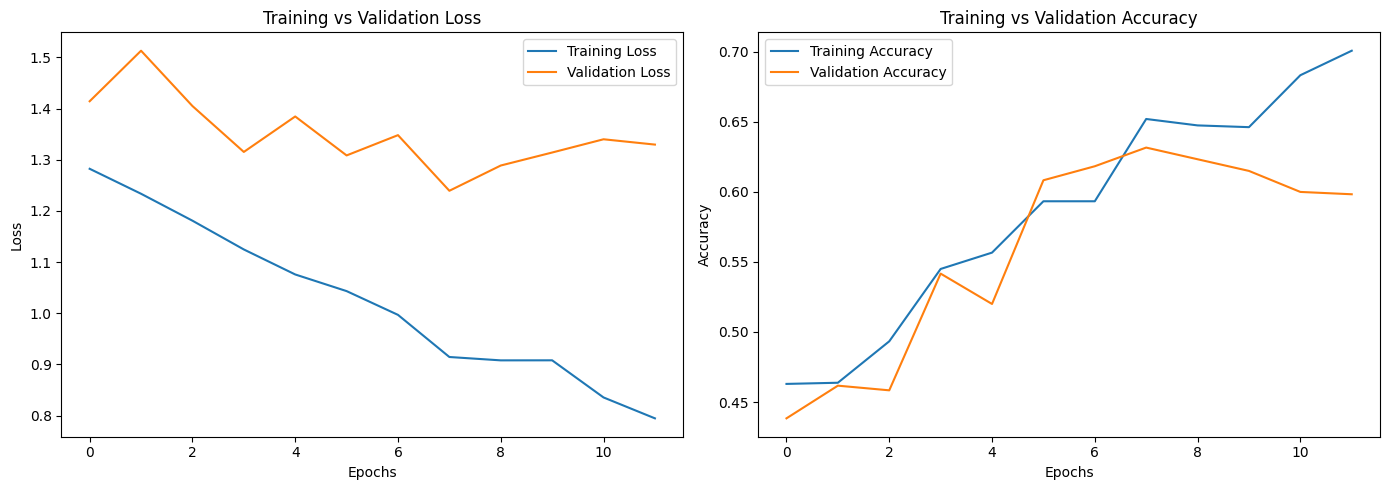

In [ ]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axs[0].plot(baseline_history.history['loss'], label='Training Loss')
axs[0].plot(baseline_history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(baseline_history.history['accuracy'], label='Training Accuracy')
axs[1].plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 352s 15s/step
Classification Report:

                 precision    recall  f1-score   support

    glass_waste       0.78      0.38      0.51       149
          metal       0.37      0.47      0.42       150
organic_garbage       0.72      0.89      0.80       150
    paper_waste       0.42      0.56      0.48       145
  plastic_waste       0.56      0.39      0.46       150

       accuracy                           0.54       744
      macro avg       0.57      0.54      0.53       744
   weighted avg       0.57      0.54      0.53       744



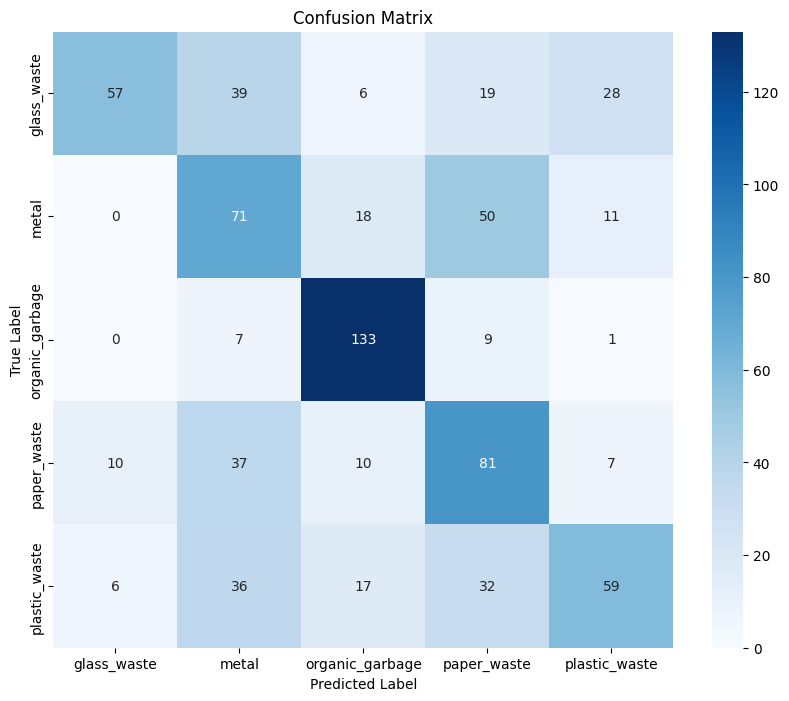

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
predictions = baseline_model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


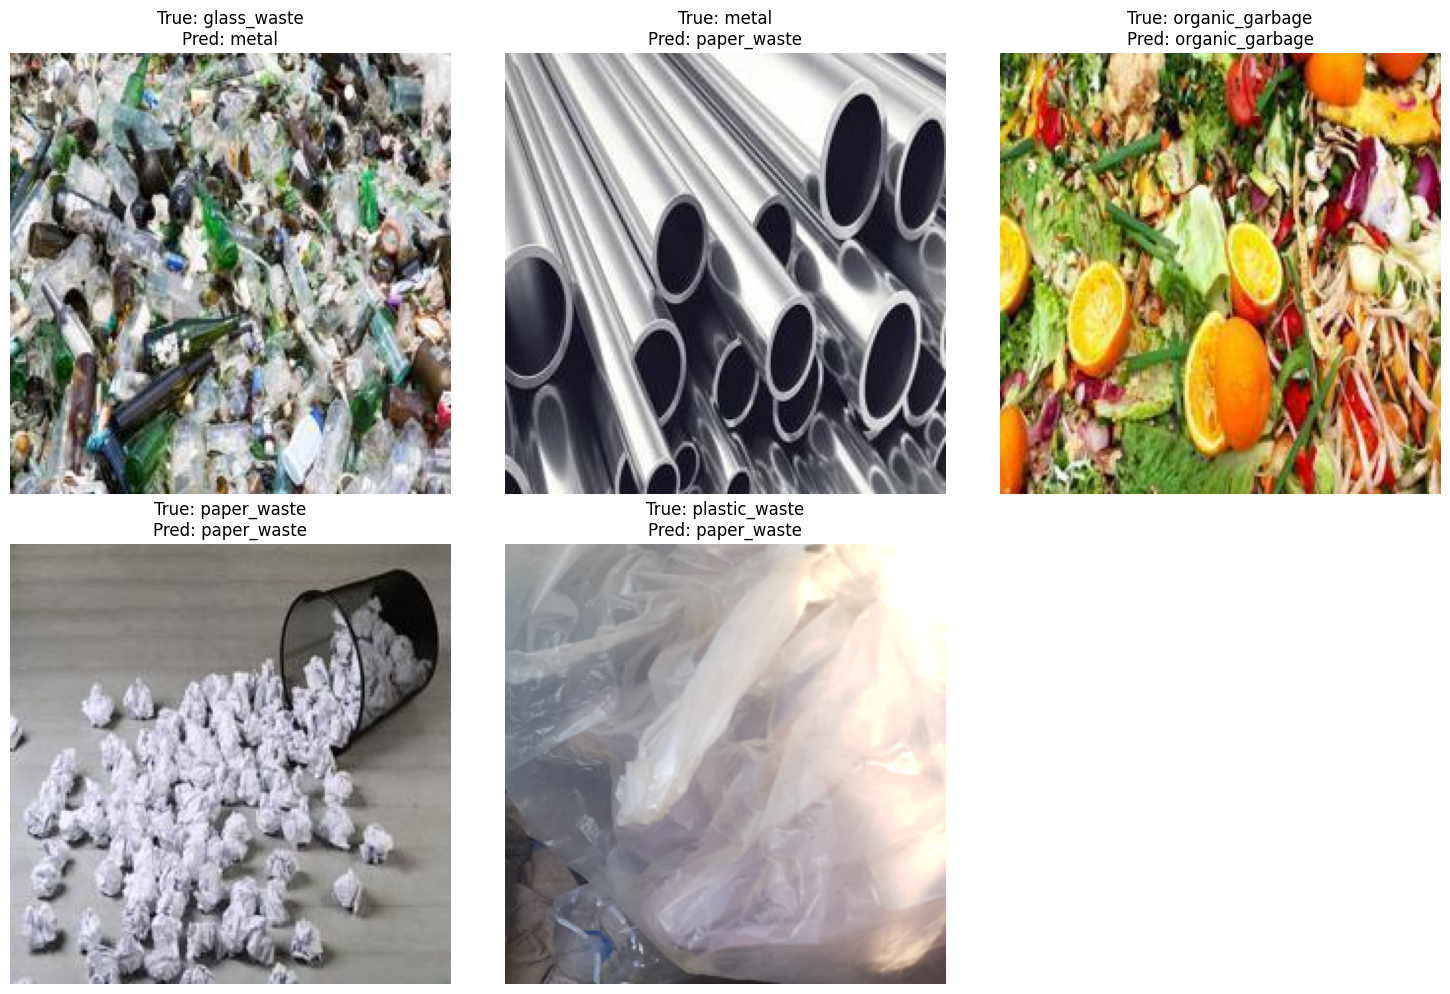

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_predictions_per_class(model, test_gen, class_labels):
    """
    Plots one image per class from the test generator with true and predicted labels.

    Parameters:
    - model: Trained model to make predictions.
    - test_gen: Data generator (e.g., from ImageDataGenerator) used for testing.
    - class_labels: List of class names corresponding to label indices.
    """
    seen_classes = set()
    images_per_class = {}

    # Collect one image per class
    for i in range(len(test_gen)):
        x_batch, y_batch = test_gen[i]
        for img, label in zip(x_batch, y_batch):
            class_idx = np.argmax(label)
            if class_idx not in seen_classes:
                images_per_class[class_idx] = img
                seen_classes.add(class_idx)
            if len(seen_classes) == len(class_labels):
                break
        if len(seen_classes) == len(class_labels):
            break

    # Plot images with predictions
    plt.figure(figsize=(15, 10))

    for i, (class_idx, img) in enumerate(images_per_class.items()):
        img_input = np.expand_dims(img, axis=0)
        pred = model.predict(img_input)
        pred_class = np.argmax(pred)

        true_label = class_labels[class_idx]
        pred_label = class_labels[pred_class]

        plt.subplot(2, int(np.ceil(len(class_labels)/2)), i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_predictions_per_class(baseline_model, test_gen, class_labels)


### **Design, Train , and Evaluate Deeper Architecture with Regularization Layer**
**Model Architecture**

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
num_classes = 5  # Update if your dataset has different classes

# Define improved model
deeper_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compile
deeper_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print Model Summary
deeper_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 849,189 (3.24 MB)

 Trainable params: 847,781 (3.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

**Model Training**

**Compiling the Model**

In [21]:
# training the deeper model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path to save the best model
best_model_path = '/content/drive/MyDrive/best_deeper_model.h5'

# New early stopping for deeper model
early_stop_deeper = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
    )


In [22]:
# Define callbacks: early stopping, model checkpoint, and reduce learning rate
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_deeper_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)


In [26]:
import time

# === Training the model ===
start_time = time.time()

history_deeper = deeper_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,  # You can increase or decrease
    verbose=2,
    callbacks=[early_stop_deeper, checkpoint, reduce_lr]
)

end_time = time.time()
deeper_training_time = end_time - start_time

print(f"\n Deeper model training time: {deeper_training_time:.2f} seconds")

Epoch 1/30

Epoch 1: val_loss improved from inf to 3.39143, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 115s - 2s/step - accuracy: 0.5875 - loss: 2.4786 - val_accuracy: 0.3200 - val_loss: 3.3914 - learning_rate: 5.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 3.39143 to 2.74845, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 52s - 691ms/step - accuracy: 0.6029 - loss: 2.3695 - val_accuracy: 0.4717 - val_loss: 2.7484 - learning_rate: 5.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.74845 to 2.60384, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 53s - 706ms/step - accuracy: 0.6183 - loss: 2.2557 - val_accuracy: 0.5050 - val_loss: 2.6038 - learning_rate: 5.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 2.60384 to 2.52004, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 52s - 699ms/step - accuracy: 0.6408 - loss: 2.1461 - val_accuracy: 0.5067 - val_loss: 2.5200 - learning_rate: 5.0000e-04
Epoch 5/30

Epoch 5: val_loss did not improve from 2.52004
75/75 - 52s - 691ms/step - accuracy: 0.6463 - loss: 2.0663 - val_accuracy: 0.4933 - val_loss: 2.9930 - learning_rate: 5.0000e-04
Epoch 6/30

Epoch 6: val_loss improved from 2.52004 to 2.05617, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 52s - 699ms/step - accuracy: 0.6600 - loss: 1.9751 - val_accuracy: 0.6533 - val_loss: 2.0562 - learning_rate: 5.0000e-04
Epoch 7/30

Epoch 7: val_loss did not improve from 2.05617
75/75 - 52s - 694ms/step - accuracy: 0.6683 - loss: 1.8897 - val_accuracy: 0.6500 - val_loss: 2.0864 - learning_rate: 5.0000e-04
Epoch 8/30

Epoch 8: val_loss did not improve from 2.05617

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
75/75 - 52s - 693ms/step - accuracy: 0.6692 - loss: 1.8451 - val_accuracy: 0.5467 - val_loss: 2.7975 - learning_rate: 5.0000e-04
Epoch 9/30

Epoch 9: val_loss improved from 2.05617 to 2.01344, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 53s - 704ms/step - accuracy: 0.6946 - loss: 1.7387 - val_accuracy: 0.6633 - val_loss: 2.0134 - learning_rate: 2.5000e-04
Epoch 10/30

Epoch 10: val_loss did not improve from 2.01344
75/75 - 51s - 683ms/step - accuracy: 0.7079 - loss: 1.6771 - val_accuracy: 0.6017 - val_loss: 2.1191 - learning_rate: 2.5000e-04
Epoch 11/30

Epoch 11: val_loss did not improve from 2.01344

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
75/75 - 52s - 694ms/step - accuracy: 0.7246 - loss: 1.6069 - val_accuracy: 0.5500 - val_loss: 2.3414 - learning_rate: 2.5000e-04
Epoch 12/30

Epoch 12: val_loss did not improve from 2.01344
75/75 - 52s - 687ms/step - accuracy: 0.7454 - loss: 1.5571 - val_accuracy: 0.6400 - val_loss: 2.0865 - learning_rate: 1.2500e-04
Epoch 13/30

Epoch 13: val_loss improved from 2.01344 to 1.94313, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 51s - 684ms/step - accuracy: 0.7387 - loss: 1.5424 - val_accuracy: 0.6867 - val_loss: 1.9431 - learning_rate: 1.2500e-04
Epoch 14/30

Epoch 14: val_loss did not improve from 1.94313
75/75 - 56s - 749ms/step - accuracy: 0.7433 - loss: 1.5084 - val_accuracy: 0.6867 - val_loss: 1.9846 - learning_rate: 1.2500e-04
Epoch 15/30

Epoch 15: val_loss improved from 1.94313 to 1.83400, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 53s - 708ms/step - accuracy: 0.7571 - loss: 1.4872 - val_accuracy: 0.7183 - val_loss: 1.8340 - learning_rate: 1.2500e-04
Epoch 16/30

Epoch 16: val_loss improved from 1.83400 to 1.77909, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 53s - 704ms/step - accuracy: 0.7538 - loss: 1.4647 - val_accuracy: 0.7217 - val_loss: 1.7791 - learning_rate: 1.2500e-04
Epoch 17/30

Epoch 17: val_loss did not improve from 1.77909
75/75 - 52s - 693ms/step - accuracy: 0.7608 - loss: 1.4391 - val_accuracy: 0.7233 - val_loss: 1.7881 - learning_rate: 1.2500e-04
Epoch 18/30

Epoch 18: val_loss did not improve from 1.77909

Epoch 18: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
75/75 - 53s - 712ms/step - accuracy: 0.7671 - loss: 1.4136 - val_accuracy: 0.7033 - val_loss: 1.8161 - learning_rate: 1.2500e-04
Epoch 19/30

Epoch 19: val_loss did not improve from 1.77909
75/75 - 52s - 690ms/step - accuracy: 0.7738 - loss: 1.3868 - val_accuracy: 0.7133 - val_loss: 1.7865 - learning_rate: 6.2500e-05
Epoch 20/30

Epoch 20: val_loss improved from 1.77909 to 1.74575, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 52s - 699ms/step - accuracy: 0.7846 - loss: 1.3635 - val_accuracy: 0.7200 - val_loss: 1.7458 - learning_rate: 6.2500e-05
Epoch 21/30

Epoch 21: val_loss did not improve from 1.74575
75/75 - 90s - 1s/step - accuracy: 0.7808 - loss: 1.3595 - val_accuracy: 0.7067 - val_loss: 1.7489 - learning_rate: 6.2500e-05
Epoch 22/30

Epoch 22: val_loss improved from 1.74575 to 1.69579, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 74s - 985ms/step - accuracy: 0.8037 - loss: 1.3260 - val_accuracy: 0.7483 - val_loss: 1.6958 - learning_rate: 6.2500e-05
Epoch 23/30

Epoch 23: val_loss did not improve from 1.69579
75/75 - 53s - 703ms/step - accuracy: 0.7917 - loss: 1.3212 - val_accuracy: 0.7217 - val_loss: 1.7421 - learning_rate: 6.2500e-05
Epoch 24/30

Epoch 24: val_loss improved from 1.69579 to 1.65060, saving model to /content/drive/MyDrive/best_deeper_model.h5


75/75 - 55s - 730ms/step - accuracy: 0.7912 - loss: 1.3326 - val_accuracy: 0.7417 - val_loss: 1.6506 - learning_rate: 6.2500e-05
Epoch 25/30

Epoch 25: val_loss did not improve from 1.65060
75/75 - 51s - 684ms/step - accuracy: 0.7937 - loss: 1.3174 - val_accuracy: 0.7283 - val_loss: 1.7158 - learning_rate: 6.2500e-05
Epoch 26/30

Epoch 26: val_loss did not improve from 1.65060

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
75/75 - 52s - 695ms/step - accuracy: 0.7900 - loss: 1.3009 - val_accuracy: 0.7183 - val_loss: 1.7109 - learning_rate: 6.2500e-05
Epoch 27/30

Epoch 27: val_loss did not improve from 1.65060
75/75 - 52s - 692ms/step - accuracy: 0.8033 - loss: 1.2699 - val_accuracy: 0.7167 - val_loss: 1.7595 - learning_rate: 3.1250e-05
Epoch 28/30

Epoch 28: val_loss did not improve from 1.65060

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
75/75 - 51s - 683ms/step - accuracy: 0.8017 - loss: 1.2751 - val_accuracy: 0.7550 -

**Model Evaluation**

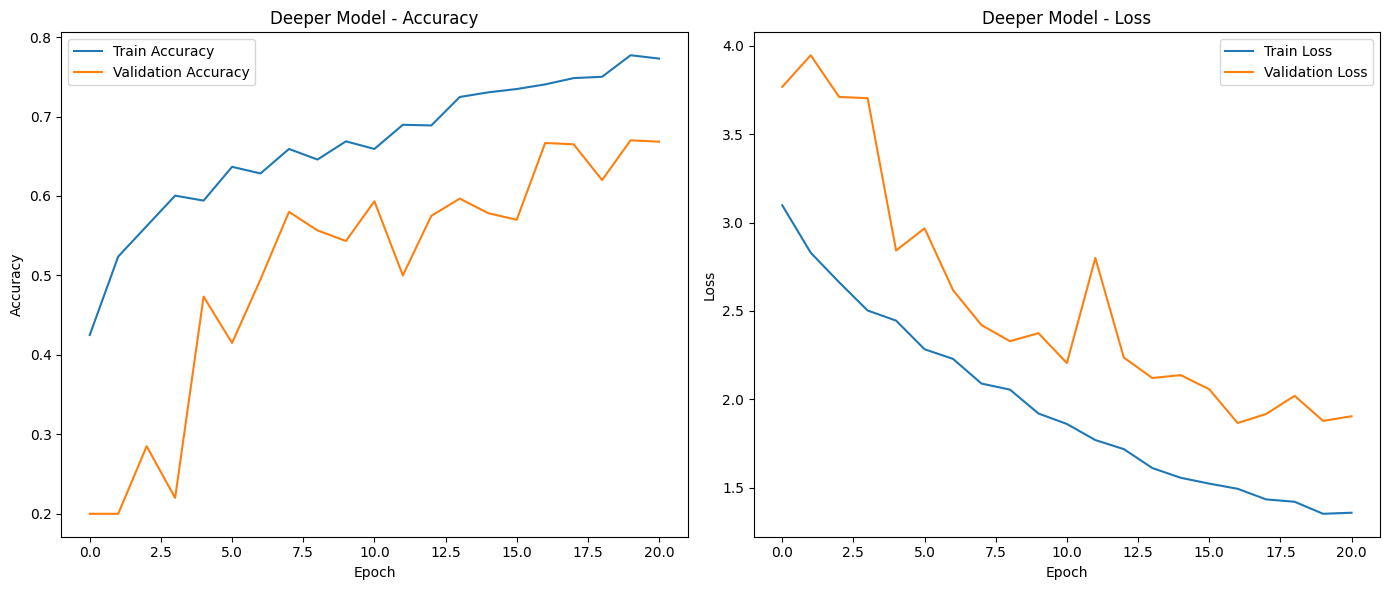

In [ ]:
import matplotlib.pyplot as plt

# Plotting function for a single model
def plot_single_history(history, title):
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot only the deeper model
plot_single_history(history_deeper, 'Deeper Model')


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step
Classification Report:

                 precision    recall  f1-score   support

    glass_waste       0.92      0.54      0.68       149
          metal       0.46      0.62      0.53       150
organic_garbage       0.57      0.98      0.72       150
    paper_waste       0.76      0.42      0.54       145
  plastic_waste       0.55      0.42      0.48       150

       accuracy                           0.60       744
      macro avg       0.65      0.60      0.59       744
   weighted avg       0.65      0.60      0.59       744



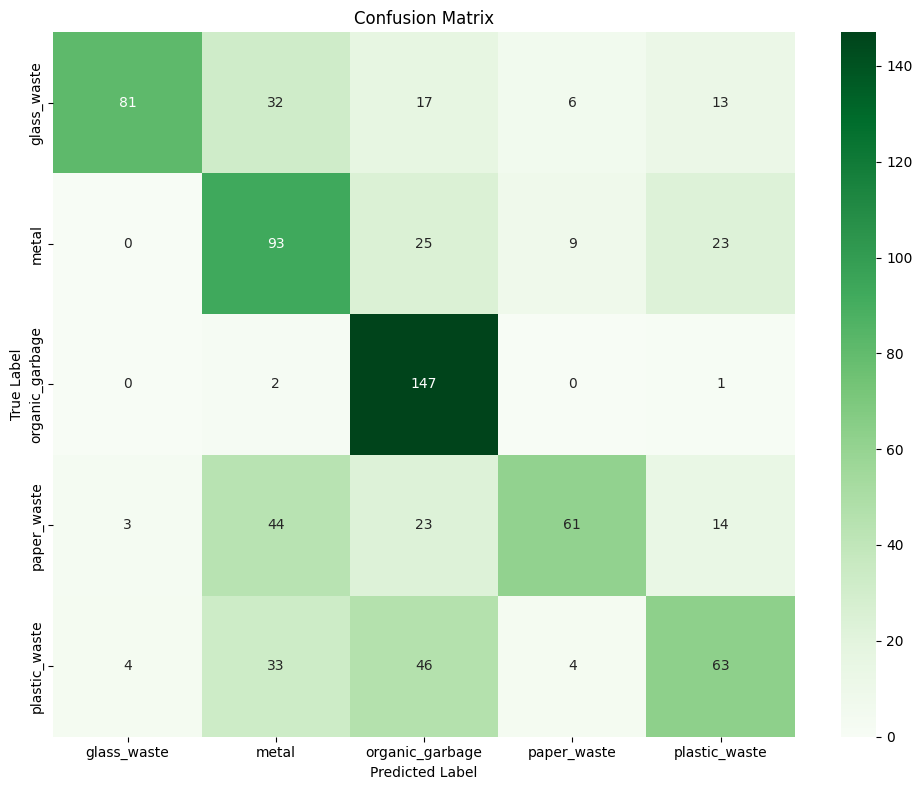

Validation Loss: 2.1653
Validation Accuracy: 0.5981


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_performance(model, test_gen):

    # Reset generator for accurate predictions
    test_gen.reset()

    # True and predicted labels
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Class labels
    target_names = list(test_gen.class_indices.keys())

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Loss and accuracy
    loss, accuracy = model.evaluate(test_gen, verbose=0)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

evaluate_model_performance(deeper_model, test_gen)


In [ ]:
val_loss, val_accuracy = deeper_model.evaluate(val_gen)
print(f'Validation Accuracy: {val_accuracy:.4f}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - accuracy: 0.6405 - loss: 1.9264
Validation Accuracy: 0.6483


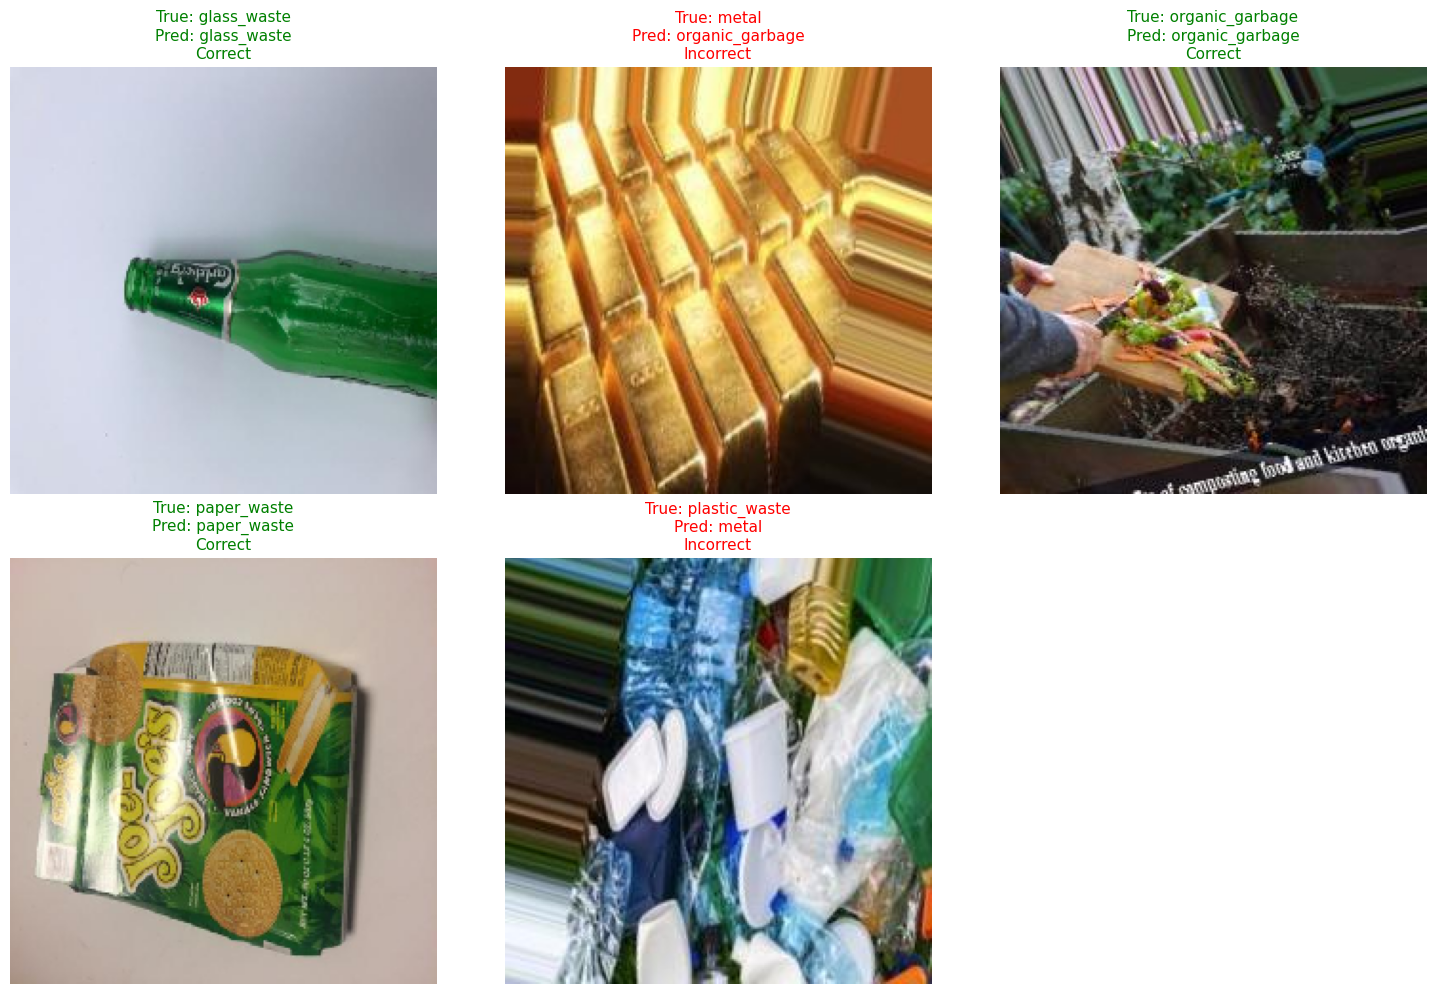

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_sample_predictions_per_class(model, test_gen, class_labels):
    """
    Plots one randomly selected image per class from the test generator with true and predicted labels.

    Parameters:
    - model: Trained model to make predictions.
    - test_gen: Data generator used for testing.
    - class_labels: List of class names corresponding to label indices.
    """
    class_labels = ['glass_waste', 'metal', 'organic_garbage', 'paper_waste', 'plastic_waste']
    class_samples = {i: [] for i in range(len(class_labels))}

    # Collect multiple samples per class
    for i in range(len(test_gen)):
        x_batch, y_batch = test_gen[i]
        for img, label in zip(x_batch, y_batch):
            class_idx = np.argmax(label)
            class_samples[class_idx].append(img)
        if all(class_samples.values()):  # if every class has at least one image
            continue

    # Randomly select one image per class
    selected_images = {class_idx: random.choice(images)
                       for class_idx, images in class_samples.items() if images}

    # Plot the selected images and predictions
    plt.figure(figsize=(15, 10))

    for i, (class_idx, img) in enumerate(selected_images.items()):
        img_input = np.expand_dims(img, axis=0)
        pred = model.predict(img_input, verbose=0)
        pred_class = np.argmax(pred)

        true_label = class_labels[class_idx]
        pred_label = class_labels[pred_class]
        color = 'green' if true_label == pred_label else 'red'

        plt.subplot(2, int(np.ceil(len(class_labels)/2)), i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}\n{'Correct' if true_label == pred_label else 'Incorrect'}",
                  color=color, fontsize=11)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


plot_sample_predictions_per_class(deeper_model, test_gen, class_labels)


### **Experimentation and Comparative Analysis**
**Baseline vs. Deeper Model Performance**

In [ ]:
val_loss, val_accuracy = baseline_model.evaluate(test_gen)
print(f'Test Accuracy: {val_accuracy:.4f}')

val_loss, val_accuracy = deeper_model.evaluate(test_gen)
print(f'Test Accuracy: {val_accuracy:.4f}')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.5509 - loss: 1.4749
Test Accuracy: 0.5390
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.6302 - loss: 2.0806
Test Accuracy: 0.5981


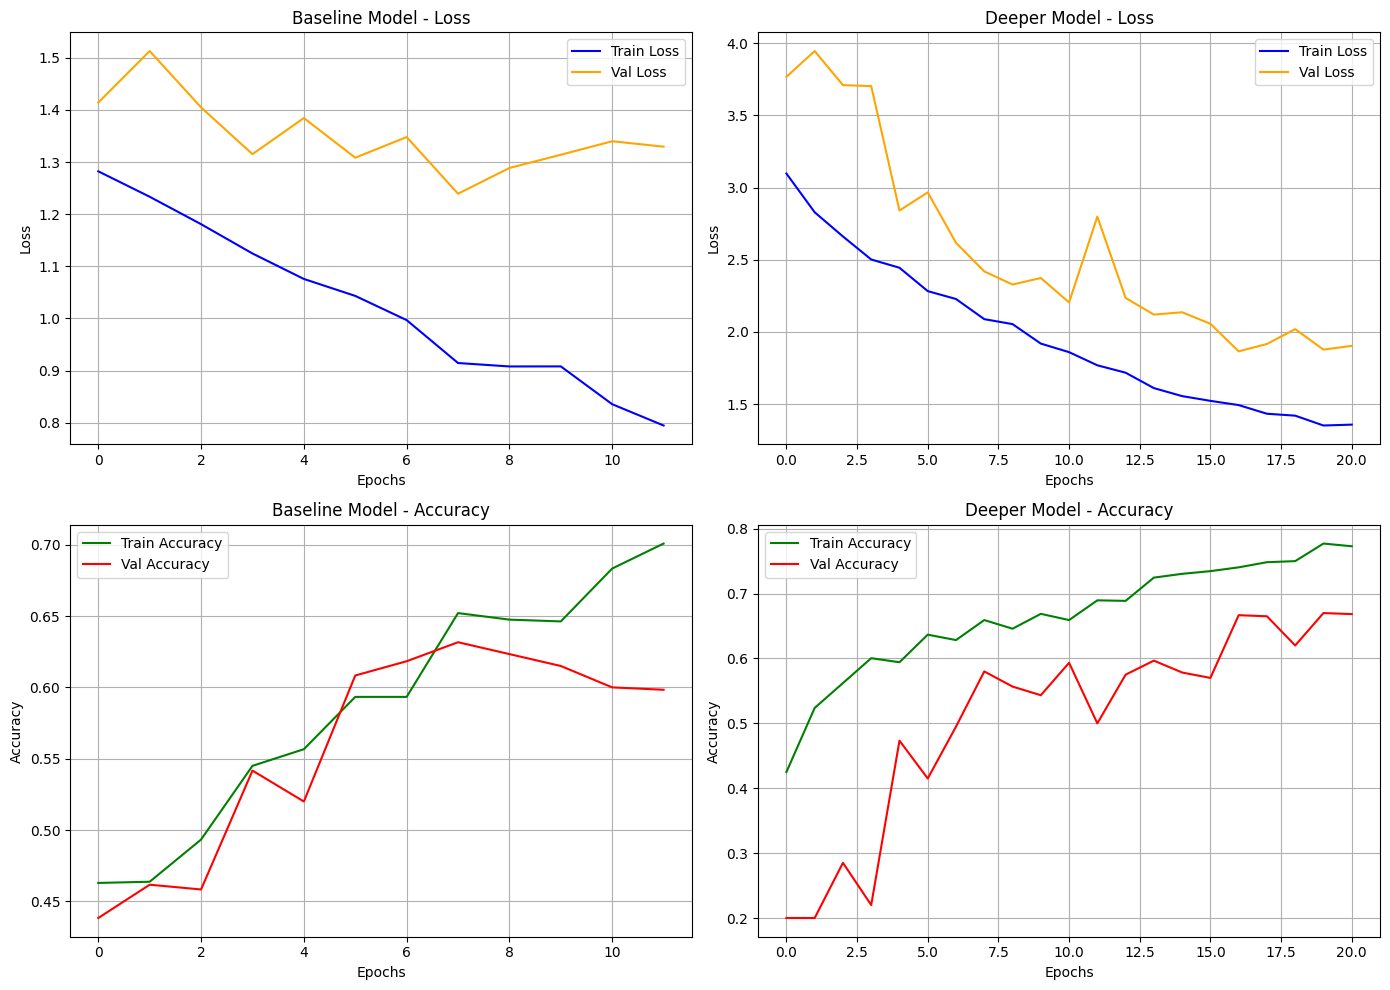

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# 1. Baseline Loss (Train vs Val)
plt.subplot(2, 2, 1)
plt.plot(baseline_history.history['loss'], label='Train Loss', color='blue')
plt.plot(baseline_history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Baseline Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Deeper Loss (Train vs Val)
plt.subplot(2, 2, 2)
plt.plot(history_deeper.history['loss'], label='Train Loss', color='blue')
plt.plot(history_deeper.history['val_loss'], label='Val Loss', color='orange')
plt.title('Deeper Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Baseline Accuracy (Train vs Val)
plt.subplot(2, 2, 3)
plt.plot(baseline_history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(baseline_history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Baseline Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 4. Deeper Accuracy (Train vs Val)
plt.subplot(2, 2, 4)
plt.plot(history_deeper.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history_deeper.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Deeper Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Computational Efficiency**

Baseline Model Training Time: 1332.85 seconds
Deeper Model Training Time: 1261.82 seconds


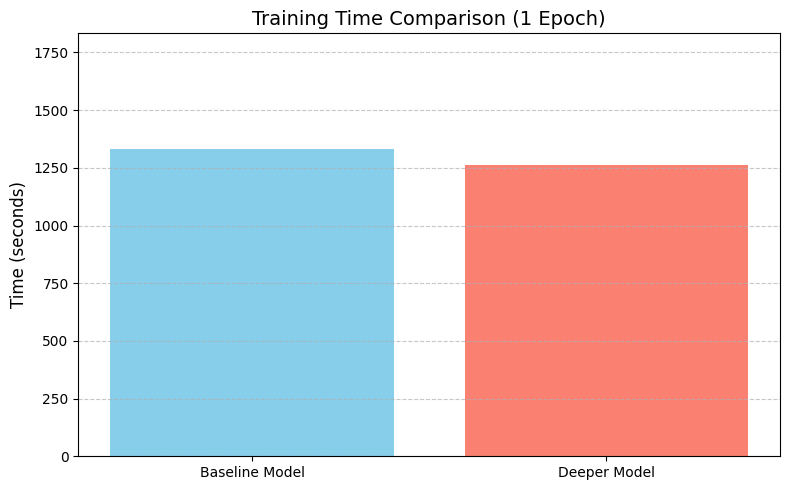

In [ ]:
import time
import matplotlib.pyplot as plt

# Timing Baseline Model
print(f"Baseline Model Training Time: {training_time:.2f} seconds")

# Timing Deeper Model
print(f"Deeper Model Training Time: {deeper_training_time:.2f} seconds")

# Data
model_names = ['Baseline Model', 'Deeper Model']
training_times = [training_time, deeper_training_time]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(model_names, training_times, color=['skyblue', 'salmon'])

plt.title('Training Time Comparison (1 Epoch)', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=12)
plt.ylim(0, max(training_times) + 500)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Optimizer Analysis: SGD vs Adam**

In [37]:
# SGD Optimizer Training
from tensorflow.keras.optimizers import SGD

# Create new deeper model again for fresh training
deeper_model_sgd = Sequential([
     Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
           kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



In [38]:
# Compile with SGD
deeper_model_sgd.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

In [40]:

sgd_start_time = time.time()
# Train deeper model with SGD
history_sgd = deeper_model_sgd.fit(
    train_gen,
    # steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    # validation_steps=len(val_gen),
    epochs=10,       # same or more epochs to observe convergence
    callbacks=[early_stop_deeper],
    verbose=2
)

sgd_end_time = time.time()
sgd_training_time = sgd_end_time - sgd_start_time

print(f"Model training time: {sgd_training_time:.2f} seconds")


Epoch 1/10
75/75 - 74s - 982ms/step - accuracy: 0.4150 - loss: 3.1862 - val_accuracy: 0.1967 - val_loss: 3.5264
Epoch 2/10
75/75 - 51s - 686ms/step - accuracy: 0.4796 - loss: 2.9396 - val_accuracy: 0.2283 - val_loss: 3.4031
Epoch 3/10
75/75 - 51s - 683ms/step - accuracy: 0.5075 - loss: 2.8329 - val_accuracy: 0.2817 - val_loss: 3.4132
Epoch 4/10
75/75 - 52s - 690ms/step - accuracy: 0.5392 - loss: 2.7634 - val_accuracy: 0.2833 - val_loss: 3.6030
Epoch 5/10
75/75 - 51s - 676ms/step - accuracy: 0.5633 - loss: 2.6502 - val_accuracy: 0.3117 - val_loss: 3.6371
Epoch 6/10
75/75 - 51s - 684ms/step - accuracy: 0.5788 - loss: 2.5895 - val_accuracy: 0.4533 - val_loss: 3.2290
Epoch 7/10
75/75 - 51s - 681ms/step - accuracy: 0.5921 - loss: 2.5256 - val_accuracy: 0.4083 - val_loss: 3.4881
Epoch 8/10
75/75 - 82s - 1s/step - accuracy: 0.6012 - loss: 2.4458 - val_accuracy: 0.3800 - val_loss: 2.9662
Epoch 9/10
75/75 - 51s - 683ms/step - accuracy: 0.6092 - loss: 2.3721 - val_accuracy: 0.2600 - val_loss: 4.

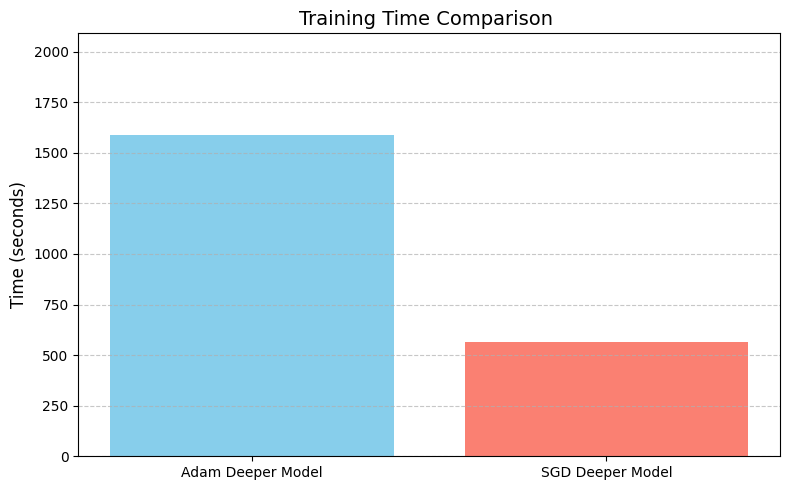

In [41]:
import matplotlib.pyplot as plt

# Data
model_names = ['Adam Deeper Model', 'SGD Deeper Model']
training_times = [deeper_training_time, sgd_training_time]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(model_names, training_times, color=['skyblue', 'salmon'])

plt.title('Training Time Comparison ', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=12)
plt.ylim(0, max(training_times) + 500)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step
Classification Report:

                 precision    recall  f1-score   support

    glass_waste       1.00      0.03      0.06       149
          metal       0.36      0.70      0.48       150
organic_garbage       0.69      0.77      0.73       150
    paper_waste       0.39      0.59      0.47       145
  plastic_waste       0.48      0.21      0.29       150

       accuracy                           0.46       744
      macro avg       0.59      0.46      0.41       744
   weighted avg       0.59      0.46      0.41       744



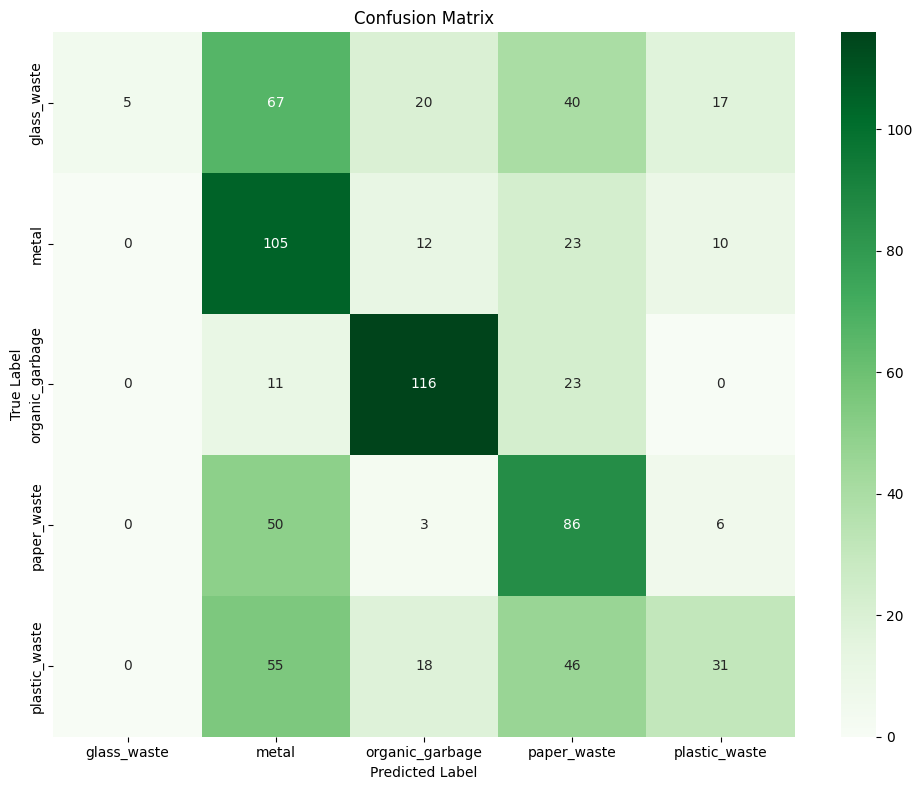

Validation Loss: 2.9533
Validation Accuracy: 0.4610


In [42]:
evaluate_model_performance(deeper_model_sgd, test_gen)


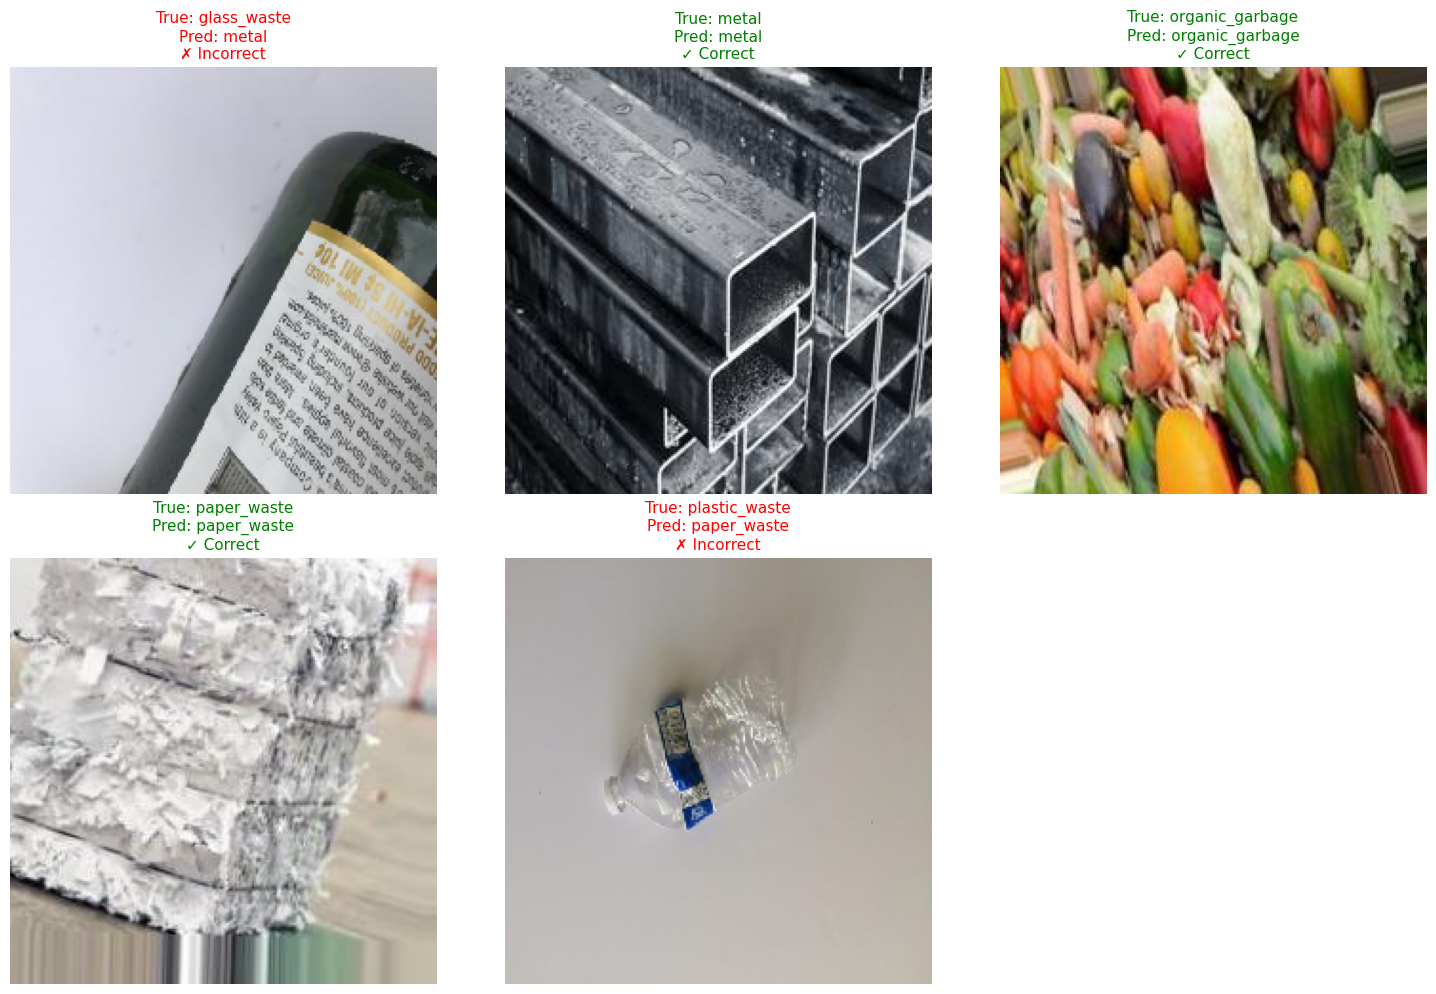

In [66]:
plot_sample_predictions_per_class(deeper_model_sgd, test_gen, class_labels)

**Compare SGD vs Adam: Loss and Accuracy Curves**

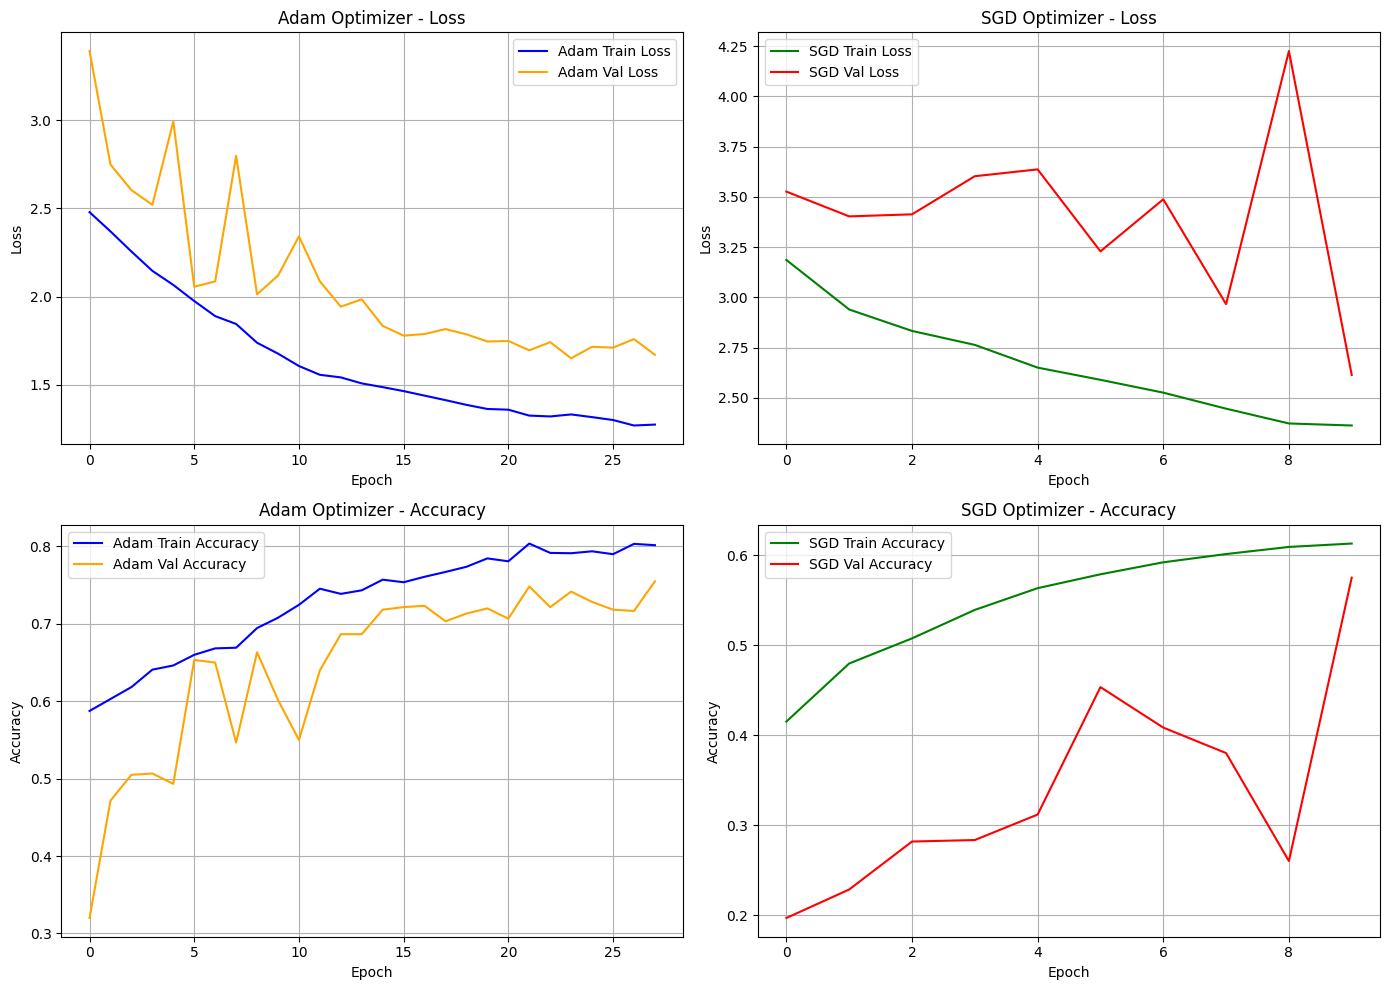

In [43]:
import matplotlib.pyplot as plt

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# --- 1. Adam Loss (Train vs Val) ---
axs[0, 0].plot(history_deeper.history['loss'], label='Adam Train Loss', color='blue')
axs[0, 0].plot(history_deeper.history['val_loss'], label='Adam Val Loss', color='orange')
axs[0, 0].set_title('Adam Optimizer - Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# --- 2. SGD Loss (Train vs Val) ---
axs[0, 1].plot(history_sgd.history['loss'], label='SGD Train Loss', color='green')
axs[0, 1].plot(history_sgd.history['val_loss'], label='SGD Val Loss', color='red')
axs[0, 1].set_title('SGD Optimizer - Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- 3. Adam Accuracy (Train vs Val) ---
axs[1, 0].plot(history_deeper.history['accuracy'], label='Adam Train Accuracy', color='blue')
axs[1, 0].plot(history_deeper.history['val_accuracy'], label='Adam Val Accuracy', color='orange')
axs[1, 0].set_title('Adam Optimizer - Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# --- 4. SGD Accuracy (Train vs Val) ---
axs[1, 1].plot(history_sgd.history['accuracy'], label='SGD Train Accuracy', color='green')
axs[1, 1].plot(history_sgd.history['val_accuracy'], label='SGD Val Accuracy', color='red')
axs[1, 1].set_title('SGD Optimizer - Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout nicely
plt.tight_layout()
plt.show()


**Challenges & Observations**

In [45]:

print("\ Challenges and Observations")
print(f"Deeper model training time: {deeper_training_time:.2f} seconds")
print(f"Deeper model with SGD training time: {sgd_training_time:.2f} seconds")

\ Challenges and Observations
Deeper model training time: 1590.31 seconds
Deeper model with SGD training time: 566.71 seconds


In [46]:
# Detect if GPU/TPU
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("No GPU detected, using CPU.")


GPU detected: /device:GPU:0


### **Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning)**<br>
**Loading and Adapting a Pre - Trained Model**

In [112]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 5
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5
MODEL_PATH = '/content/drive/MyDrive/best_transfer_model.h5'
EPOCHS_FEATURE = 20
EPOCHS_FINE_TUNE = 20

In [111]:
import time
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 2. Load Pretrained Base Model (VGG16) ---
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE)

# --- Freeze all convolutional
base_model.trainable = False

In [113]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# --- 3. Build Custom Classification Head ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [114]:
# Full model
model = Model(inputs=base_model.input, outputs=output)

# --- 4. Compile the Model (Feature Extraction) ---
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [115]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,767,365 (60.15 MB)

 Trainable params: 1,052,677 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train Only New Layers (Feature Extraction Phase)**

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

# # Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

In [117]:
checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, verbose=1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, min_lr=1e-6)

In [118]:
print("\n--- Feature Extraction Phase ---")
start_feature = time.time()

history_feature = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FEATURE,
    callbacks=[early_stop, checkpoint, lr_reduce],
    verbose=2
)

end_feature = time.time()
print(f"Feature extraction training time: {end_feature - start_feature:.2f} seconds")


--- Feature Extraction Phase ---
Epoch 1/20

Epoch 1: val_loss improved from inf to 1.45058, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 60s - 804ms/step - accuracy: 0.2671 - loss: 1.6161 - val_accuracy: 0.4733 - val_loss: 1.4506 - learning_rate: 1.0000e-04
Epoch 2/20

Epoch 2: val_loss improved from 1.45058 to 1.37162, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 59s - 789ms/step - accuracy: 0.4175 - loss: 1.3871 - val_accuracy: 0.4700 - val_loss: 1.3716 - learning_rate: 1.0000e-04
Epoch 3/20

Epoch 3: val_loss did not improve from 1.37162
75/75 - 53s - 713ms/step - accuracy: 0.4846 - loss: 1.2463 - val_accuracy: 0.4617 - val_loss: 1.4173 - learning_rate: 1.0000e-04
Epoch 4/20

Epoch 4: val_loss did not improve from 1.37162

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
75/75 - 82s - 1s/step - accuracy: 0.5100 - loss: 1.1725 - val_accuracy: 0.4767 - val_loss: 1.4026 - learning_rate: 1.0000e-04
Epoch 5/20

Epoch 5: val_loss improved from 1.37162 to 1.35032, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 58s - 770ms/step - accuracy: 0.5492 - loss: 1.1175 - val_accuracy: 0.5133 - val_loss: 1.3503 - learning_rate: 3.0000e-05
Epoch 6/20

Epoch 6: val_loss did not improve from 1.35032
75/75 - 53s - 712ms/step - accuracy: 0.5483 - loss: 1.1138 - val_accuracy: 0.5050 - val_loss: 1.3758 - learning_rate: 3.0000e-05
Epoch 7/20

Epoch 7: val_loss improved from 1.35032 to 1.34670, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 56s - 742ms/step - accuracy: 0.5542 - loss: 1.0845 - val_accuracy: 0.5100 - val_loss: 1.3467 - learning_rate: 3.0000e-05
Epoch 8/20

Epoch 8: val_loss did not improve from 1.34670
75/75 - 62s - 829ms/step - accuracy: 0.5629 - loss: 1.0599 - val_accuracy: 0.5067 - val_loss: 1.3549 - learning_rate: 3.0000e-05
Epoch 9/20

Epoch 9: val_loss improved from 1.34670 to 1.33228, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 64s - 849ms/step - accuracy: 0.5625 - loss: 1.0697 - val_accuracy: 0.5267 - val_loss: 1.3323 - learning_rate: 3.0000e-05
Epoch 10/20

Epoch 10: val_loss improved from 1.33228 to 1.32985, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 57s - 758ms/step - accuracy: 0.5717 - loss: 1.0342 - val_accuracy: 0.5450 - val_loss: 1.3299 - learning_rate: 3.0000e-05
Epoch 11/20

Epoch 11: val_loss did not improve from 1.32985
75/75 - 53s - 709ms/step - accuracy: 0.5825 - loss: 1.0232 - val_accuracy: 0.5333 - val_loss: 1.3437 - learning_rate: 3.0000e-05
Epoch 12/20

Epoch 12: val_loss improved from 1.32985 to 1.32493, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 55s - 733ms/step - accuracy: 0.5846 - loss: 1.0211 - val_accuracy: 0.5300 - val_loss: 1.3249 - learning_rate: 3.0000e-05
Epoch 13/20

Epoch 13: val_loss improved from 1.32493 to 1.29878, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 55s - 734ms/step - accuracy: 0.6033 - loss: 1.0010 - val_accuracy: 0.5467 - val_loss: 1.2988 - learning_rate: 3.0000e-05
Epoch 14/20

Epoch 14: val_loss did not improve from 1.29878
75/75 - 55s - 735ms/step - accuracy: 0.5987 - loss: 0.9822 - val_accuracy: 0.5550 - val_loss: 1.3275 - learning_rate: 3.0000e-05
Epoch 15/20

Epoch 15: val_loss improved from 1.29878 to 1.29781, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 55s - 734ms/step - accuracy: 0.5979 - loss: 0.9772 - val_accuracy: 0.5800 - val_loss: 1.2978 - learning_rate: 3.0000e-05
Epoch 16/20

Epoch 16: val_loss did not improve from 1.29781
75/75 - 56s - 744ms/step - accuracy: 0.6104 - loss: 0.9674 - val_accuracy: 0.5650 - val_loss: 1.3012 - learning_rate: 3.0000e-05
Epoch 17/20

Epoch 17: val_loss improved from 1.29781 to 1.27259, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 54s - 718ms/step - accuracy: 0.6246 - loss: 0.9469 - val_accuracy: 0.5633 - val_loss: 1.2726 - learning_rate: 3.0000e-05
Epoch 18/20

Epoch 18: val_loss did not improve from 1.27259
75/75 - 81s - 1s/step - accuracy: 0.6279 - loss: 0.9303 - val_accuracy: 0.5783 - val_loss: 1.2846 - learning_rate: 3.0000e-05
Epoch 19/20

Epoch 19: val_loss did not improve from 1.27259

Epoch 19: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
75/75 - 52s - 699ms/step - accuracy: 0.6321 - loss: 0.9224 - val_accuracy: 0.5800 - val_loss: 1.2865 - learning_rate: 3.0000e-05
Epoch 20/20

Epoch 20: val_loss improved from 1.27259 to 1.26711, saving model to /content/drive/MyDrive/best_transfer_model.h5


75/75 - 56s - 747ms/step - accuracy: 0.6317 - loss: 0.9103 - val_accuracy: 0.5833 - val_loss: 1.2671 - learning_rate: 9.0000e-06
Feature extraction training time: 1178.12 seconds


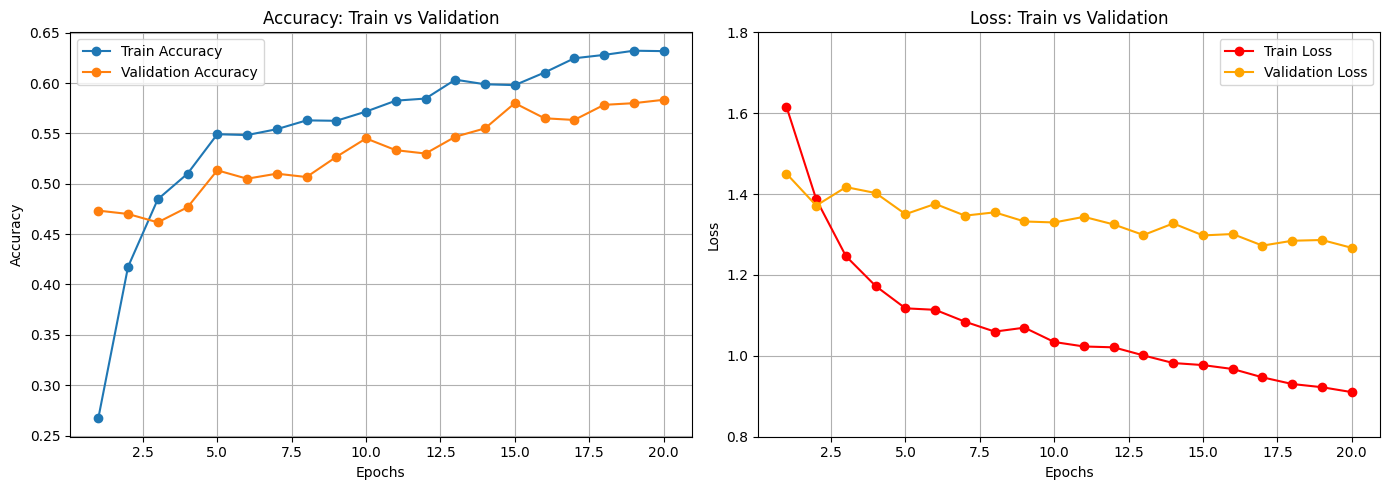

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Extract history
acc = history_feature.history['accuracy']
val_acc = history_feature.history['val_accuracy']
loss = history_feature.history['loss']
val_loss = history_feature.history['val_loss']
epochs = range(1, len(acc) + 1)

# Create subplots
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss', marker='o', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Loss: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# ✅ Set Y-axis ticks at interval of 0.2 (just the labels)
current_ylim = plt.ylim()  # get current limits without changing anything
yticks = np.arange(np.floor(current_ylim[0] * 5) / 5, np.ceil(current_ylim[1] * 5) / 5 + 0.2, 0.2)
plt.yticks(yticks)

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Fine-Tune the Model**

In [124]:
# Unfreeze only Block 5 (last block)
for layer in base_model.layers:  # Usually conv5_1, conv5_2, conv5_3, and pool5
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [125]:

# Define new best model path
fine_tune_best_model_path = '/content/drive/MyDrive/best_finetuned_model.h5'

# Define ModelCheckpoint for fine-tuning
fine_tune_checkpoint = ModelCheckpoint(fine_tune_best_model_path,
                                       monitor='val_loss',
                                       save_best_only=True,
                                       verbose=1)

In [126]:
# Fine-tuning
fine_start = time.time()
history_finetune= model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, fine_tune_checkpoint],
    verbose=2)

fine_end = time.time()
finetuning_training_time= fine_end - fine_start
print(f"Fine-tuning time: {finetuning_training_time:.2f} seconds")

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.07263, saving model to /content/drive/MyDrive/best_finetuned_model.h5


75/75 - 79s - 1s/step - accuracy: 0.6900 - loss: 0.7891 - val_accuracy: 0.6833 - val_loss: 1.0726
Epoch 2/20

Epoch 2: val_loss improved from 1.07263 to 0.96607, saving model to /content/drive/MyDrive/best_finetuned_model.h5


75/75 - 76s - 1s/step - accuracy: 0.7696 - loss: 0.6224 - val_accuracy: 0.7250 - val_loss: 0.9661
Epoch 3/20

Epoch 3: val_loss did not improve from 0.96607
75/75 - 70s - 928ms/step - accuracy: 0.7933 - loss: 0.5434 - val_accuracy: 0.7583 - val_loss: 0.9787
Epoch 4/20

Epoch 4: val_loss improved from 0.96607 to 0.81513, saving model to /content/drive/MyDrive/best_finetuned_model.h5


75/75 - 74s - 992ms/step - accuracy: 0.8354 - loss: 0.4626 - val_accuracy: 0.7767 - val_loss: 0.8151
Epoch 5/20

Epoch 5: val_loss improved from 0.81513 to 0.81225, saving model to /content/drive/MyDrive/best_finetuned_model.h5


75/75 - 76s - 1s/step - accuracy: 0.8508 - loss: 0.4206 - val_accuracy: 0.7783 - val_loss: 0.8123
Epoch 6/20

Epoch 6: val_loss did not improve from 0.81225
75/75 - 73s - 977ms/step - accuracy: 0.8679 - loss: 0.3595 - val_accuracy: 0.8017 - val_loss: 0.9473
Epoch 7/20

Epoch 7: val_loss did not improve from 0.81225
75/75 - 71s - 948ms/step - accuracy: 0.8808 - loss: 0.3315 - val_accuracy: 0.8167 - val_loss: 1.2224
Epoch 8/20

Epoch 8: val_loss improved from 0.81225 to 0.71222, saving model to /content/drive/MyDrive/best_finetuned_model.h5


75/75 - 66s - 879ms/step - accuracy: 0.9029 - loss: 0.3005 - val_accuracy: 0.7983 - val_loss: 0.7122
Epoch 9/20

Epoch 9: val_loss improved from 0.71222 to 0.71015, saving model to /content/drive/MyDrive/best_finetuned_model.h5


75/75 - 71s - 945ms/step - accuracy: 0.9125 - loss: 0.2720 - val_accuracy: 0.8350 - val_loss: 0.7101
Epoch 10/20

Epoch 10: val_loss did not improve from 0.71015
75/75 - 69s - 921ms/step - accuracy: 0.9167 - loss: 0.2339 - val_accuracy: 0.7883 - val_loss: 0.7737
Epoch 11/20

Epoch 11: val_loss did not improve from 0.71015
75/75 - 62s - 833ms/step - accuracy: 0.9175 - loss: 0.2394 - val_accuracy: 0.8300 - val_loss: 0.8519
Epoch 12/20

Epoch 12: val_loss did not improve from 0.71015
75/75 - 62s - 833ms/step - accuracy: 0.9196 - loss: 0.2291 - val_accuracy: 0.8467 - val_loss: 0.7177
Epoch 13/20

Epoch 13: val_loss did not improve from 0.71015
75/75 - 61s - 812ms/step - accuracy: 0.9433 - loss: 0.1704 - val_accuracy: 0.8183 - val_loss: 1.0239
Epoch 14/20

Epoch 14: val_loss did not improve from 0.71015
75/75 - 82s - 1s/step - accuracy: 0.9417 - loss: 0.1689 - val_accuracy: 0.8283 - val_loss: 0.9408
Fine-tuning time: 995.45 seconds


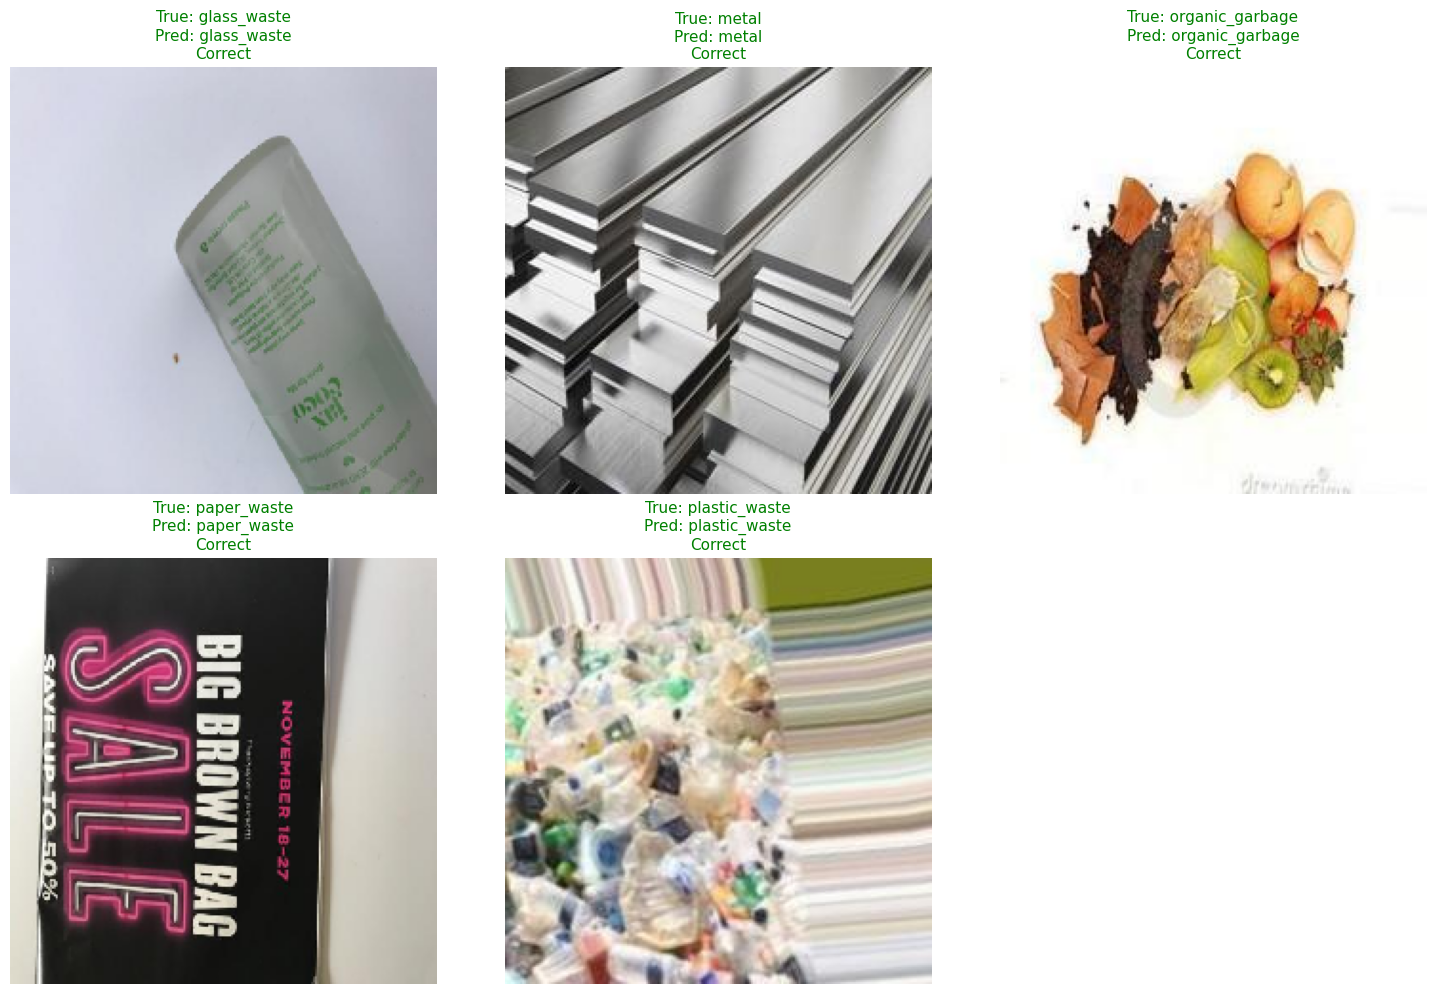

In [110]:
plot_sample_predictions_per_class(model, test_gen, class_labels)

**Evaluate Fine-Tuned Model**

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step
Classification Report:

                 precision    recall  f1-score   support

    glass_waste       0.97      0.66      0.78       149
          metal       0.69      0.89      0.78       150
organic_garbage       0.64      0.91      0.75       150
    paper_waste       0.86      0.54      0.67       145
  plastic_waste       0.66      0.63      0.64       150

       accuracy                           0.73       744
      macro avg       0.76      0.73      0.72       744
   weighted avg       0.76      0.73      0.73       744



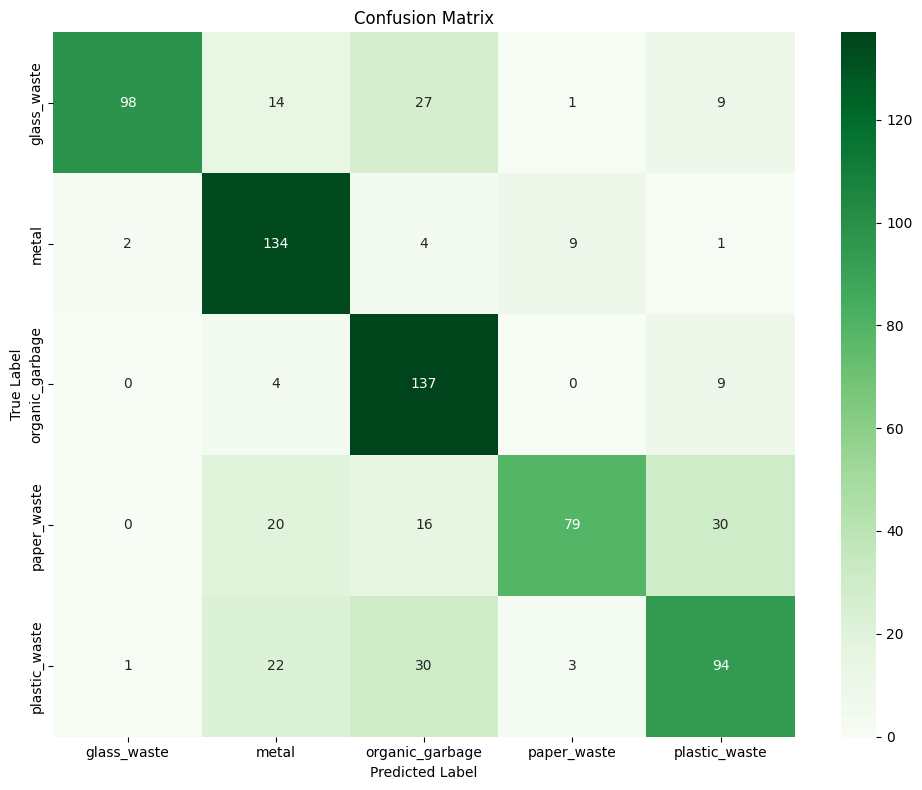

Validation Loss: 1.4827
Validation Accuracy: 0.7285


In [108]:
evaluate_model_performance(model, test_gen)

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step
Classification Report:

                 precision    recall  f1-score   support

    glass_waste       0.97      0.66      0.78       149
          metal       0.69      0.89      0.78       150
organic_garbage       0.64      0.91      0.75       150
    paper_waste       0.86      0.54      0.67       145
  plastic_waste       0.66      0.63      0.64       150

       accuracy                           0.73       744
      macro avg       0.76      0.73      0.72       744
   weighted avg       0.76      0.73      0.73       744



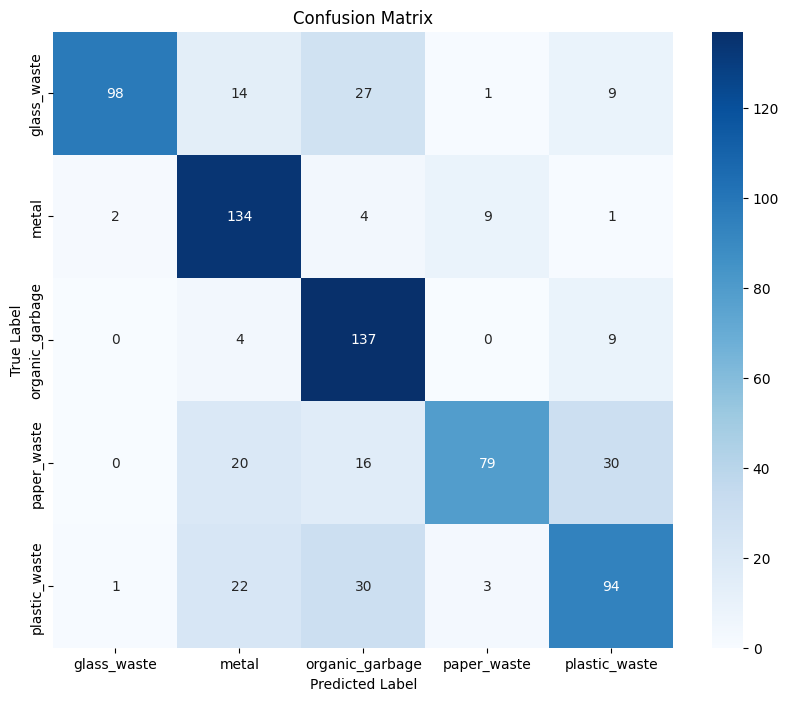

In [109]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


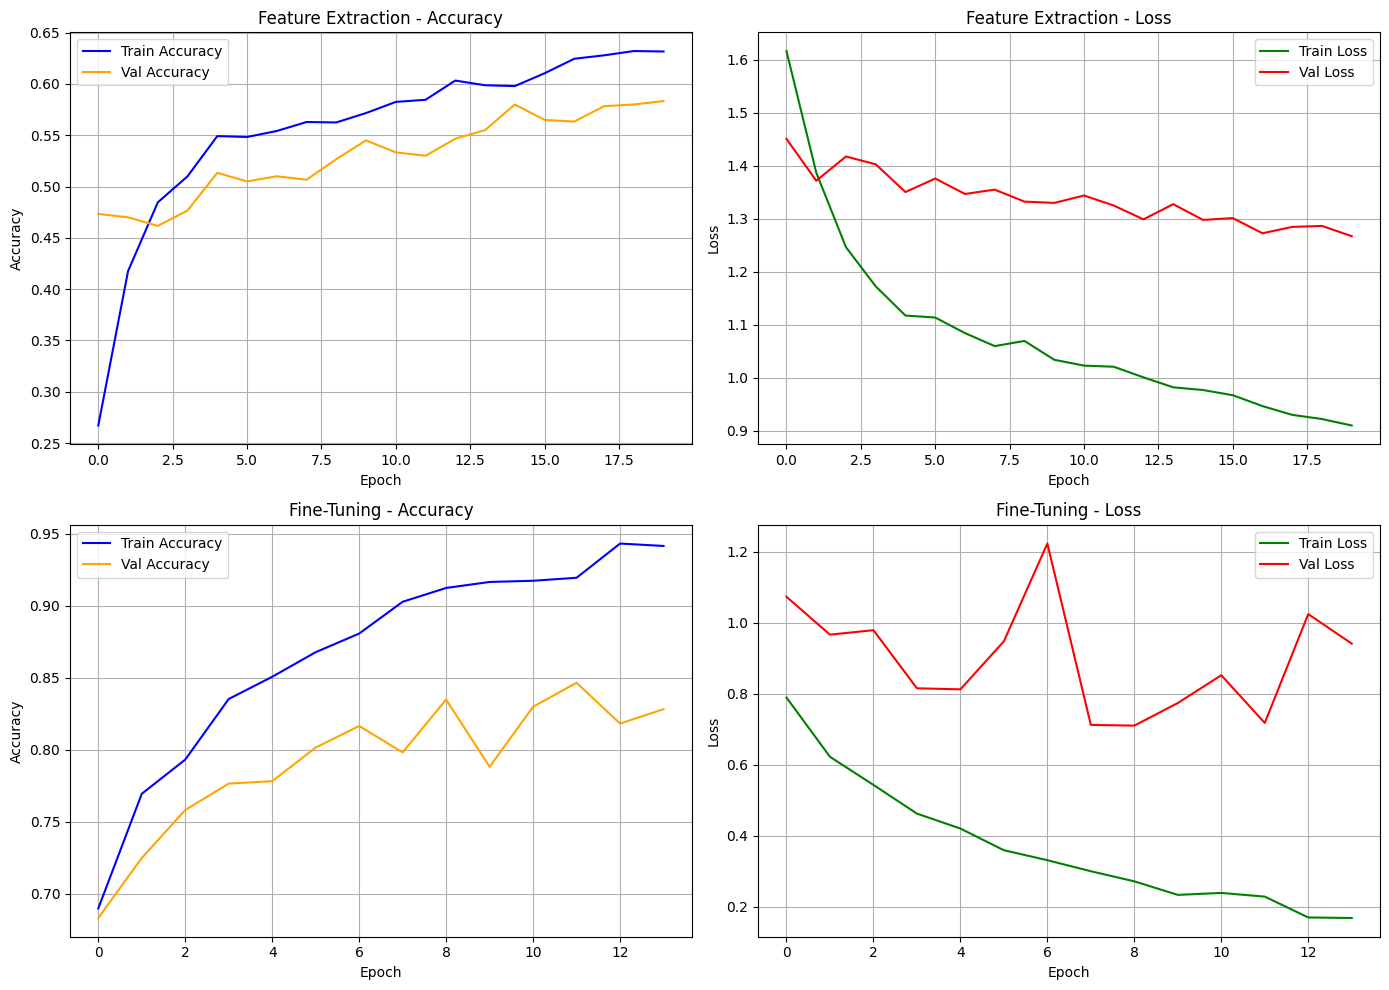

In [129]:
import matplotlib.pyplot as plt

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# --- 1. Feature Extraction Accuracy ---
axs[0, 0].plot(history_feature.history['accuracy'], label='Train Accuracy', color='blue')
axs[0, 0].plot(history_feature.history['val_accuracy'], label='Val Accuracy', color='orange')
axs[0, 0].set_title('Feature Extraction - Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# --- 2. Feature Extraction Loss ---
axs[0, 1].plot(history_feature.history['loss'], label='Train Loss', color='green')
axs[0, 1].plot(history_feature.history['val_loss'], label='Val Loss', color='red')
axs[0, 1].set_title('Feature Extraction - Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- 3. Fine-Tuning Accuracy ---
axs[1, 0].plot(history_finetune.history['accuracy'], label='Train Accuracy', color='blue')
axs[1, 0].plot(history_finetune.history['val_accuracy'], label='Val Accuracy', color='orange')
axs[1, 0].set_title('Fine-Tuning - Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# --- 4. Fine-Tuning Loss ---
axs[1, 1].plot(history_finetune.history['loss'], label='Train Loss', color='green')
axs[1, 1].plot(history_finetune.history['val_loss'], label='Val Loss', color='red')
axs[1, 1].set_title('Fine-Tuning - Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()
